In [1]:
%%time
#Import the things
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from numpy import hstack
from numpy import array
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

#Import the models
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

CPU times: user 2.82 s, sys: 858 ms, total: 3.67 s
Wall time: 8.4 s


In [2]:
%%time
#Prep to read in the data
file_path_unleaded = "~/Desktop/UtahMSBA/Capstone3/Data/unleaded.csv"
file_path_diesel = "~/Desktop/UtahMSBA/Capstone3/Data/diesel.csv"
file_path_indoor = "~/Desktop/UtahMSBA/Capstone3/Data/indoor.csv"
file_path_food = "~/Desktop/UtahMSBA/Capstone3/Data/food.csv"
def load_the_data(file_path_unleaded,file_path_diesel,file_path_indoor,file_path_food):
    unleaded_data = pd.DataFrame(pd.read_csv(file_path_unleaded))
    diesel_data = pd.DataFrame(pd.read_csv(file_path_diesel))
    indoor_data = pd.DataFrame(pd.read_csv(file_path_indoor))
    food_data = pd.DataFrame(pd.read_csv(file_path_food))
    return unleaded_data, diesel_data, indoor_data, food_data

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10 µs


In [3]:
%%time
#Read in the data
unleaded, diesel, indoor, food = load_the_data(file_path_unleaded, file_path_diesel, file_path_indoor, file_path_food)

CPU times: user 382 ms, sys: 129 ms, total: 511 ms
Wall time: 670 ms


In [ ]:
%%time
#Create needed functions

In [5]:
%%time
def prep_the_data_not_sim(dataset):
    
    #Remove site 23065 as per class notes
    dataset = dataset.drop(dataset[dataset.site_id_msba == 23065].index)
    
    #Get list of stores and the number of stores.
    stores_list = dataset['site_id_msba'].unique().tolist()
    num_stores = len(stores_list)
    num_holdout = num_stores - math.floor(.8 *num_stores)
    
    #Randomly choose
    #holdout_stores = random.sample(stores_list,num_holdout)
    #simulation = random.sample(holdout_stores, 5)
    #train_stores = [store for store in stores_list if store not in holdout_stores]
    #holdout_stores = [store for store in holdout_stores if store not in simulation]
    
    #Use specific stores -In this case, these were randomly chosen from a previous run of the random choose
    holdout_stores = [22330, 22120, 22400, 24150, 21980, 22715, 22085, 22820]
    simulation = [24150, 21980, 22715, 22085, 22820]
    train_stores = [store for store in stores_list if store not in holdout_stores]
    holdout_stores = [store for store in holdout_stores if store not in simulation]
    
    #Notify
    print(f'The stores being used for training are {train_stores}.')
    print(f'The stores held out for final validation are {holdout_stores}.')
    print(f'The stores being used for simulation are {simulation}.')
    
    #Get indexes
    train_data_idx = dataset.index[dataset['site_id_msba'].isin(train_stores)]
    val_data_idx = dataset.index[dataset['site_id_msba'].isin(holdout_stores)]
    sim_idx = dataset.index[dataset['site_id_msba'].isin(simulation)]
    
    #Get important split numbers
    split_idx = len(train_data_idx)
    
    #Spereate into train and val for rearrange
    train_data = dataset.loc[train_data_idx]
    val_data = dataset.loc[val_data_idx]
    #Sim too
    sim_data = dataset.loc[sim_idx]
    
    #Get sim indexes
    sim_data1_idx = sim_data.index[sim_data['site_id_msba'] == simulation[0]]
    sim_data2_idx = sim_data.index[sim_data['site_id_msba'] == simulation[1]]
    sim_data3_idx = sim_data.index[sim_data['site_id_msba'] == simulation[2]]
    sim_data4_idx = sim_data.index[sim_data['site_id_msba'] == simulation[3]]
    sim_data5_idx = sim_data.index[sim_data['site_id_msba'] == simulation[4]]
    
    #Separate out for the sim data
    sim_data1 = sim_data.loc[sim_data1_idx]
    sim_data2 = sim_data.loc[sim_data2_idx]
    sim_data3 = sim_data.loc[sim_data3_idx]
    sim_data4 = sim_data.loc[sim_data4_idx]
    sim_data5 = sim_data.loc[sim_data5_idx]
    
    #Recombine the data that will be used in training and validation
    dataset = pd.concat([train_data, val_data], axis=0)
    
    #Remove columns not needed for training
    dataset = dataset.drop(columns=['site_id_msba', 'calendar.calendar_day_date','capital_projects.soft_opening_date', 'calendar.day_of_week'])
    
    #Shift to numpy not needed as it is already
    dataset = dataset.to_numpy()
    
    #Seperate into train and val
    train_data = dataset[:split_idx]
    val_data = dataset[split_idx:]
    
    #Create y and X for use in kfold later
    y = train_data[:, 0]
    X = train_data[:,1:]
    
    #Create y_val and X_val for use in final validation
    y_val = val_data[:,0]
    X_val = val_data[:,1:]
    
    return X, X_val, y, y_val, holdout_stores, sim_data1, sim_data2, sim_data3, sim_data4, sim_data5

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs


In [6]:
%%time
def create_meta_dataset(data_x, yhat1, yhat2, yhat3, yhat4, yhat6, yhat7):
    #Again a thanks to Jason Brownlee
    #just to be sure
    data_x = array(data_x)
    #give extra dimension to the vectors
    yhat1 = array(yhat1).reshape((len(yhat1), 1))
    yhat2 = array(yhat2).reshape((len(yhat2), 1))
    yhat3 = array(yhat3).reshape((len(yhat3), 1))
    yhat4 = array(yhat4).reshape((len(yhat4), 1))
    yhat6 = array(yhat6).reshape((len(yhat6), 1))
    yhat7 = array(yhat7).reshape((len(yhat7), 1))
    #stack as separate columns
    meta_X = np.append(data_x, yhat1, axis = 1)
    meta_X = np.append(meta_X, yhat2, axis = 1)
    meta_X = np.append(meta_X, yhat3, axis = 1)
    meta_X = np.append(meta_X, yhat4, axis = 1)
    meta_X = np.append(meta_X, yhat6, axis = 1)
    meta_X = np.append(meta_X, yhat7, axis = 1)
    return meta_X

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [7]:
%%time
def kfold_and_meta_dataset_creations(X,y):
    #Big thanks to Jason Brownlee with help on the structure here.
    
    #Create all the needed lists
    data_x, data_y, tree_yhat, rf_yhat, x_tree_yhat, sv_yhat, lasso_yhat, ridge_yhat, ols_yhat = list(), list(), list(), list(), list(), list(), list(), list(), list()
    
    #Create kfolds
    n_splits = 10
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    #Run the models over the different folds
    rounds = 1
    for train, test in kfold.split(X):
        print(f'Round {rounds}/{n_splits}...')
        #Create the train and test sets
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        #Collect data
        data_x.extend(X_test)
        data_y.extend(y_test)
        
        #This next bit could easily be put in a function. Doing the long way for my own understanding.
        
        #Decision Trees
        model1 = DecisionTreeRegressor()
        model1.fit(X_train, y_train)
        yhat1 = model1.predict(X_test)
        tree_yhat.extend(yhat1)
        
        #Random Forests
        model2 = RandomForestRegressor()
        model2.fit(X_train, y_train)
        yhat2 = model2.predict(X_test)
        rf_yhat.extend(yhat2)
        
        #Extra Trees
        model3 = ExtraTreesRegressor()
        model3.fit(X_train, y_train)
        yhat3 = model3.predict(X_test)
        x_tree_yhat.extend(yhat3)
        
        #SVM
        model4 = SVR()
        model4.fit(X_train, y_train)
        yhat4 = model4.predict(X_test)
        sv_yhat.extend(yhat4)
        
        #Lasso
        #model5 = Lasso()
        #model5.fit(X_train, y_train)
        #yhat5 = model5.predict(X_test)
        #lasso_yhat.extend(yhat5)
        
        #Ridge
        model6 = Ridge()
        model6.fit(X_train, y_train)
        yhat6 = model6.predict(X_test)
        ridge_yhat.extend(yhat6)
        
        #OLS
        model7 = LinearRegression()
        model7.fit(X_train, y_train)
        yhat7 = model4.predict(X_test)
        ols_yhat.extend(yhat7)
        
        #Increase round counter
        rounds = rounds + 1
    
    #Create the big data set
    print('Creating meta data sets...')
    meta_X = create_meta_dataset(data_x, tree_yhat, rf_yhat, x_tree_yhat, sv_yhat, ridge_yhat, ols_yhat)
    print('Done.')
    return meta_X, data_y   

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [8]:
%%time
def stack_prediction(model1, model2, model3, model4, model6, model7, X):
    #predict submodels
    yhat1 = model1.predict(X)#[:, 0] adding this last bit I think eliminates the reshape in the create fxn
    yhat2 = model2.predict(X)#[:, 0] #predict_proba is super useful for this step in classification problems.
    yhat3 = model3.predict(X)#[:, 0]
    yhat4 = model4.predict(X)#[:, 0]
    yhat6 = model6.predict(X)#[:, 0]
    yhat7 = model7.predict(X)#[:, 0]
    
    #create meta prediction table
    meta_X_val = create_meta_dataset(X, yhat1, yhat2, yhat3, yhat4, yhat6, yhat7)
    
    
    
    return meta_X_val, yhat1, yhat2, yhat3, yhat4, yhat6, yhat7
    
    
    

CPU times: user 6 µs, sys: 5 µs, total: 11 µs
Wall time: 32.7 µs


In [9]:
%%time
def run_XGB_with_validation(X, X_val, meta_X, y, y_val, meta_y, model = None, best_params = {'booster': 'gbtree', 'eval_metric': 'mape', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'objective': 'reg:squarederror'}):
    #Again thank you Jason Brownlee for tips in this area
    
    #fit submodels on all data
    print('Fitting final submodels on all original train data...')
    
    #Decision Trees
    model1 = DecisionTreeRegressor()
    model1.fit(X, y)
        
    #Random Forests
    model2 = RandomForestRegressor()
    model2.fit(X, y)
        
    #Extra Trees
    model3 = ExtraTreesRegressor()
    model3.fit(X, y)
        
    #SVM
    model4 = SVR()
    model4.fit(X, y)
        
    #Lasso
    #model5 = Lasso()
    #model5.fit(X, y)
        
    #Ridge
    model6 = Ridge()
    model6.fit(X, y)
        
    #OLS
    model7 = LinearRegression()
    model7.fit(X, y)
    
    #Create big X_val
    meta_X_val, yhat1, yhat2, yhat3, yhat4, yhat6, yhat7 = stack_prediction(model1, model2, model3, model4, model6, model7, X_val)
    
    #Scale everything
    scaler = MinMaxScaler(feature_range=(-1, 1))
    meta_y = array(meta_y).reshape((len(meta_y), 1))
    y_val = array(y_val).reshape((len(y_val), 1))
    
    meta_X = scaler.fit_transform(meta_X)
    meta_y = scaler.fit_transform(meta_y)
    meta_X_val = scaler.fit_transform(meta_X_val)
    y_val2 = scaler.fit_transform(y_val) #To make sure we keep this clean for validation later.
    
    #Set up the XGBoost
    
    params = {'max_depth': 6, "booster": "gbtree", 'eta': 0.3, 'objective': 'reg:squarederror', 'eval_metric':['mape','mae','rmse']}
    dtrain = xgb.DMatrix(meta_X, meta_y)
    dtest = xgb.DMatrix(meta_X_val, y_val2)
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    
    #Fit meta model on meta data
    print('Fitting meta model on meta data...')
    #meta_model = xgb.train(params, dtrain, 500, evals = watchlist, early_stopping_rounds = 100, verbose_eval = False)
    meta_model = XGBRegressor()
    
    '''#Grid Search
    print('Running grid search...')
    param_grid = {
        'max_depth': list(range(3,11,1)),
        'booster': ['gblinear','gbtree'],
        'learning_rate':[.1,.01,.05,.001],
        'n_estimators': list(range(50, 150, 50)),
        'objective':['reg:squarederror','reg:squaredlogerror'],
        'eval_metric':['mape','rmse', 'rmsle']
    }
    
    grid_search = GridSearchCV(meta_model, param_grid, n_jobs = -1, scoring = 'neg_mean_absolute_percentage_error',cv = 3).fit(meta_X, meta_y)
    best_params = grid_search.best_params_'''
    if model == None:
        meta_model = xgb.train(best_params, dtrain, 500, evals = watchlist, early_stopping_rounds = 100, verbose_eval = False)
    else: meta_model = xgb.train(best_params, dtrain, 500, xgb_model = model, evals = watchlist, early_stopping_rounds = 100, verbose_eval = False)
    #Make final predictions
    print('Making final predictions...')
    
    yhat_mm = meta_model.predict(dtest)
    
    #Unscale predictions for readability
    yhat_mm = array(yhat_mm).reshape((len(yhat_mm), 1))
    yhat_mm = scaler.inverse_transform(yhat_mm)
    
    #Outputting metrics
    print('##########Metrics##########')
    
    #Decision trees
    print('---Decision Trees---')
    mape_dt = mean_absolute_percentage_error(y_val, yhat1)
    print("MAPE:", mape_dt)
    print("|")
    
    #Random Forests
    print('---Random Forests---')
    mape_rf = mean_absolute_percentage_error(y_val, yhat2)
    print("MAPE:", mape_rf)
    print("|")
    
    #Extra trees
    print('---Extra Trees---')
    mape_et = mean_absolute_percentage_error(y_val, yhat3)
    print("MAPE:", mape_et)
    print("|")
    
    #SVM
    print('---SVM---')
    mape_svm = mean_absolute_percentage_error(y_val, yhat4)
    print("MAPE:", mape_svm)
    print("|")
    
    #Ridge
    print('---Ridge---')
    mape_ridge = mean_absolute_percentage_error(y_val, yhat6)
    print("MAPE:", mape_ridge)
    print("|")
    
    #OLS
    print('---OLS---')
    mape_ols = mean_absolute_percentage_error(y_val, yhat7)
    print("MAPE:", mape_ols)
    print("|")
    
    #Meta Model
    print('---Meta Model---')
    mape_xgb = mean_absolute_percentage_error(y_val, yhat_mm)
    print("MAPE:", mape_xgb)
    print("|")
    
    #print(best_params)
    print('Done.')
    return y_val, yhat1, yhat2, yhat3, yhat4, yhat6, yhat7, yhat_mm, meta_model

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [10]:
%%time
def run_it_all_not_sim(dataset):
    #Prep the data
    X, X_val, y, y_val, val_stores, sim_data1, sim_data2, sim_data3, sim_data4, sim_data5 = prep_the_data_not_sim(dataset)
    #Create meta datasets
    meta_X, meta_y = kfold_and_meta_dataset_creations(X,y)
    #Run XGB. Get vars for use after if needed.
    y_val, yhat1, yhat2, yhat3, yhat4, yhat6, yhat7, yhat_mm, meta_model = run_XGB_with_validation(X, X_val, meta_X, y, y_val, meta_y, model = None)
    print(val_stores)
    return y_val, yhat1, yhat2, yhat3, yhat4, yhat6, yhat7, yhat_mm, sim_data1, sim_data2, sim_data3, sim_data4, sim_data5, meta_model

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


In [11]:
%%time
y_valunleaded, yhat1unleaded, yhat2unleaded, yhat3unleaded, yhat4unleaded, yhat6unleaded, yhat7unleaded, yhat_mmunleaded, sim_data1unleaded, sim_data2unleaded, sim_data3unleaded, sim_data4unleaded, sim_data5unleaded, meta_modelunleaded = run_it_all_not_sim(unleaded)

The stores being used for training are [21560, 22015, 22260, 22505, 22540, 22575, 22645, 22680, 22750, 22785, 22855, 22890, 22925, 23135, 23240, 23345, 23380, 23415, 23450, 23485, 23555, 23660, 23730, 23765, 23835, 23905, 24220, 24255, 24535].
The stores held out for final validation are [22330, 22120, 22400].
The stores being used for simulation are [24150, 21980, 22715, 22085, 22820].
Round 1/10...
Round 2/10...
Round 3/10...
Round 4/10...
Round 5/10...
Round 6/10...
Round 7/10...
Round 8/10...
Round 9/10...
Round 10/10...
Creating meta data sets...
Done.
Fitting final submodels on all original train data...
Fitting meta model on meta data...
[21:12:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Making final predictions...
##########Metrics##########
---Decision Trees---
MAPE: 0.154939638949108
|
---Random Forests---
MAPE: 0.1157959117046728
|
---Extra T

In [12]:
%%time
y_valdiesel, yhat1diesel, yhat2diesel, yhat3diesel, yhat4diesel, yhat6diesel, yhat7diesel, yhat_mmdiesel, sim_data1diesel, sim_data2diesel, sim_data3diesel, sim_data4diesel, sim_data5diesel, meta_modeldiesel = run_it_all_not_sim(diesel)

The stores being used for training are [21560, 22015, 22260, 22505, 22540, 22575, 22645, 22680, 22750, 22785, 22855, 22890, 22925, 23135, 23240, 23345, 23380, 23415, 23450, 23485, 23555, 23660, 23730, 23765, 23835, 23905, 24220, 24255, 24535].
The stores held out for final validation are [22330, 22120, 22400].
The stores being used for simulation are [24150, 21980, 22715, 22085, 22820].
Round 1/10...
Round 2/10...
Round 3/10...
Round 4/10...
Round 5/10...
Round 6/10...
Round 7/10...
Round 8/10...
Round 9/10...
Round 10/10...
Creating meta data sets...
Done.
Fitting final submodels on all original train data...
Fitting meta model on meta data...
[21:19:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Making final predictions...
##########Metrics##########
---Decision Trees---
MAPE: 0.3368409520323868
|
---Random Forests---
MAPE: 0.22489448067910567
|
---Extra

In [13]:
%%time
y_valfood, yhat1food, yhat2food, yhat3food, yhat4food, yhat6food, yhat7food, yhat_mmfood, sim_data1food, sim_data2food, sim_data3food, sim_data4food, sim_data5food, meta_modelfood = run_it_all_not_sim(food)

The stores being used for training are [21560, 22015, 22260, 22505, 22540, 22575, 22645, 22680, 22750, 22785, 22855, 22890, 22925, 23135, 23240, 23345, 23380, 23415, 23450, 23485, 23555, 23660, 23730, 23765, 23835, 23905, 24220, 24255, 24535].
The stores held out for final validation are [22330, 22120, 22400].
The stores being used for simulation are [24150, 21980, 22715, 22085, 22820].
Round 1/10...
Round 2/10...
Round 3/10...
Round 4/10...
Round 5/10...
Round 6/10...
Round 7/10...
Round 8/10...
Round 9/10...
Round 10/10...
Creating meta data sets...
Done.
Fitting final submodels on all original train data...
Fitting meta model on meta data...
[21:25:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Making final predictions...
##########Metrics##########
---Decision Trees---
MAPE: 1.5433263744357508e+16
|
---Random Forests---
MAPE: 1.6090981718347514e+16
|
-

In [14]:
%%time
y_valindoor, yhat1indoor, yhat2indoor, yhat3indoor, yhat4indoor, yhat6indoor, yhat7indoor, yhat_mmindoor, sim_data1indoor, sim_data2indoor, sim_data3indoor, sim_data4indoor, sim_data5indoor, meta_modelindoor = run_it_all_not_sim(indoor)

The stores being used for training are [21560, 22015, 22260, 22505, 22540, 22575, 22645, 22680, 22750, 22785, 22855, 22890, 22925, 23135, 23240, 23345, 23380, 23415, 23450, 23485, 23555, 23660, 23730, 23765, 23835, 23905, 24220, 24255, 24535].
The stores held out for final validation are [22330, 22120, 22400].
The stores being used for simulation are [24150, 21980, 22715, 22085, 22820].
Round 1/10...
Round 2/10...
Round 3/10...
Round 4/10...
Round 5/10...
Round 6/10...
Round 7/10...
Round 8/10...
Round 9/10...
Round 10/10...
Creating meta data sets...
Done.
Fitting final submodels on all original train data...
Fitting meta model on meta data...
[21:31:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Making final predictions...
##########Metrics##########
---Decision Trees---
MAPE: 4.711651779500446e+16
|
---Random Forests---
MAPE: 4.85404093225682e+16
|
---E

In [15]:
%%time
def graph_absolute_error(actuals, predicteds):
    import matplotlib.pyplot as plt
    result = pd.concat([pd.DataFrame(actuals), pd.DataFrame(predicteds)], axis=1)
    result = result.reset_index()
    result.columns = ['index','x','y']
    print(result)
    absolute_errors = []
    for index, row in result.iterrows():
        absolute_error = abs(((row['x'] - row['y'])/row['x']))
        absolute_errors.append(absolute_error)
    
    plt.scatter(range(len(absolute_errors)),absolute_errors)
    plt.show()
    return('Done.')

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.2 µs


      index          x            y
0         0  1746.9340   700.234802
1         1  2158.6040  1543.916626
2         2  3138.8245  2137.435791
3         3  2513.4480  2477.617188
4         4  2440.7250  1850.055054
...     ...        ...          ...
1093   1093  2740.5175  2992.104492
1094   1094  2306.1745  2354.318604
1095   1095  2702.7420  2380.419434
1096   1096  2638.5240  2655.121826
1097   1097  2436.9030  2335.551514

[1098 rows x 3 columns]


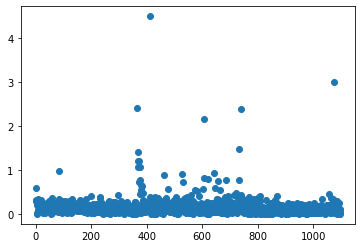

CPU times: user 414 ms, sys: 90.8 ms, total: 505 ms
Wall time: 360 ms


'Done.'

In [16]:
%%time
graph_absolute_error(y_valunleaded, yhat_mmunleaded) 

      index          x            y
0         0   248.6470   211.414993
1         1   334.1660   178.408005
2         2   521.5595   266.132141
3         3   410.3330   376.824768
4         4   333.3610   295.379211
...     ...        ...          ...
1093   1093   873.0750   919.671692
1094   1094   925.5155   773.934448
1095   1095  1411.6270  2103.830322
1096   1096  2176.5520  2030.442017
1097   1097  2447.1125  1997.408813

[1098 rows x 3 columns]


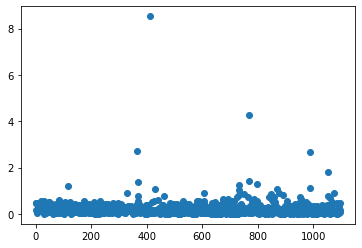

CPU times: user 139 ms, sys: 5.44 ms, total: 145 ms
Wall time: 150 ms


'Done.'

In [17]:
%%time
graph_absolute_error(y_valdiesel, yhat_mmdiesel) 

      index         x           y
0         0  345.7090  228.639084
1         1  367.0940  328.653625
2         2  490.8435  291.770844
3         3  509.4775  494.317963
4         4  440.7235  317.232086
...     ...       ...         ...
1093   1093  785.1270  817.321350
1094   1094  763.1505  546.811829
1095   1095  962.6330  809.228210
1096   1096  938.9135  896.129822
1097   1097  997.2340  877.282898

[1098 rows x 3 columns]


<timed exec>:9: RuntimeWarning: divide by zero encountered in double_scalars


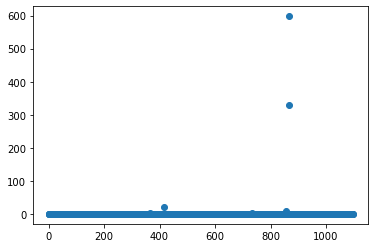

CPU times: user 154 ms, sys: 8.14 ms, total: 162 ms
Wall time: 163 ms


'Done.'

In [18]:
%%time
graph_absolute_error(y_valfood, yhat_mmfood) 

      index          x            y
0         0  1061.5360   733.104187
1         1  1201.5255   849.812988
2         2  1595.0095   931.294128
3         3  1737.6450  1325.617798
4         4  1524.5090  1019.708252
...     ...        ...          ...
1093   1093  3021.9105  2704.779297
1094   1094  2672.2780  2151.560547
1095   1095  3133.5255  2635.420654
1096   1096  3061.4360  2548.569336
1097   1097  3059.7035  2853.115723

[1098 rows x 3 columns]


<timed exec>:9: RuntimeWarning: divide by zero encountered in double_scalars


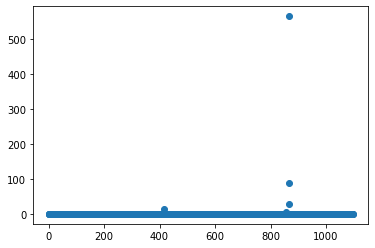

CPU times: user 152 ms, sys: 6.36 ms, total: 158 ms
Wall time: 168 ms


'Done.'

In [19]:
%%time
graph_absolute_error(y_valindoor, yhat_mmindoor) 

In [20]:
%%time
def real_full_year_sim_no_additional_training(sim_dataset, model):
    #Get our actuals
    sim_dataset = sim_dataset.drop(columns=['site_id_msba', 'calendar.calendar_day_date','capital_projects.soft_opening_date', 'calendar.day_of_week'])
    column_to_move = sim_dataset.pop("full_days_open")
    sim_dataset.insert(2,'full_days_open',column_to_move)
    y = sim_dataset.iloc[:,0].to_numpy()
    X = sim_dataset.iloc[:,1:].to_numpy()
    year_y = np.sum(y)
    year_yhats = []
    predicted_minus_actuals = []
    for i in range(len(sim_dataset)): #Go over every day
        day_idx1 = i
        day1 = day_idx1 + 1
        print(f'Running simulation for day {day1}...')
        y_hats = []
        for j in range(len(sim_dataset)): #Go over every day again to update the values
            day_idx2 = j
            day2 = day_idx2 + 1
            #print('##### Year Estimation for day {day2} #####')
            
            #Set up the prediction
            scaler = MinMaxScaler(feature_range=(-1, 1))
            
            #Get the first part of the Xs
            X_val_1 = X[day_idx2,0:-13].reshape((1, X[day_idx2,0:-13].shape[0]))
            
            #Get the second parts of the Xs
            if day2 == 1:
                X_tm1 = 0
                X_tm2 = 0
                X_tm3 = 0
                X_tm4 = 0
                X_tm5 = 0
                X_tm6 = 0
                X_tm7 = 0
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif day2 == 2:
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = 0
                X_tm3 = 0
                X_tm4 = 0
                X_tm5 = 0
                X_tm6 = 0
                X_tm7 = 0
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif day2 == 3:
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = 0
                X_tm4 = 0
                X_tm5 = 0
                X_tm6 = 0
                X_tm7 = 0
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif day2 == 4:
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = 0
                X_tm5 = 0
                X_tm6 = 0
                X_tm7 = 0
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif day2 == 5:
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = 0
                X_tm6 = 0
                X_tm7 = 0
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif day2 == 6:
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = 0
                X_tm7 = 0
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif day2 == 7:
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = 0
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif (day2 >= 8  & day2 <= 30):
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = y[day_idx2 - 7]
                X_tm30 = 0
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif (day2 >= 31  & day2 <= 60):
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = y[day_idx2 - 7]
                X_tm30 = y[day_idx2 - 30]
                X_tm60 = 0
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif (day2 >= 61  & day2 <= 90):
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = y[day_idx2 - 7]
                X_tm30 = y[day_idx2 - 30]
                X_tm60 = y[day_idx2 - 60]
                X_tm90 = 0
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif (day2 >= 91  & day2 <= 180):
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = y[day_idx2 - 7]
                X_tm30 = y[day_idx2 - 30]
                X_tm60 = y[day_idx2 - 60]
                X_tm90 = y[day_idx2 - 90]
                X_tm180 = 0
                X_tm270 = 0
                X_tm365 = 0
            elif (day2 >= 181  & day2 <= 270):
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = y[day_idx2 - 7]
                X_tm30 = y[day_idx2 - 30]
                X_tm60 = y[day_idx2 - 60]
                X_tm90 = y[day_idx2 - 90]
                X_tm180 = y[day_idx2 - 180]
                X_tm270 = 0
                X_tm365 = 0
            elif (day2 >= 271  & day2 <= 365):
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = y[day_idx2 - 7]
                X_tm30 = y[day_idx2 - 30]
                X_tm60 = y[day_idx2 - 60]
                X_tm90 = y[day_idx2 - 90]
                X_tm180 = y[day_idx2 - 180]
                X_tm270 = y[day_idx2 - 270]
                X_tm365 = 0
            else:
                X_tm1 = y[day_idx2 - 1]
                X_tm2 = y[day_idx2 - 2]
                X_tm3 = y[day_idx2 - 3]
                X_tm4 = y[day_idx2 - 4]
                X_tm5 = y[day_idx2 - 5]
                X_tm6 = y[day_idx2 - 6]
                X_tm7 = y[day_idx2 - 7]
                X_tm30 = y[day_idx2 - 30]
                X_tm60 = y[day_idx2 - 60]
                X_tm90 = y[day_idx2 - 90]
                X_tm180 = y[day_idx2 - 180]
                X_tm270 = y[day_idx2 - 270]
                X_tm365 = y[day_idx2 - 365]
            
                
            #Create X_val_2
            X_val_2 = np.concatenate([np.array([X_tm1]).reshape((1, 1)),
                                        np.array([X_tm2]).reshape((1, 1)),
                                        np.array([X_tm3]).reshape((1, 1)),
                                        np.array([X_tm4]).reshape((1, 1)),
                                        np.array([X_tm5]).reshape((1, 1)),
                                        np.array([X_tm6]).reshape((1, 1)),
                                        np.array([X_tm7]).reshape((1, 1)),
                                        np.array([X_tm30]).reshape((1, 1)),
                                        np.array([X_tm60]).reshape((1, 1)),
                                        np.array([X_tm90]).reshape((1, 1)),
                                        np.array([X_tm180]).reshape((1, 1)),
                                        np.array([X_tm270]).reshape((1, 1)),
                                        np.array([X_tm365]).reshape((1, 1))], axis = 1)
            
            
            #Combine the Xs
            X_val = np.append(X_val_1, X_val_2, axis = 1)
            
            #Y val
            y_val = y[day_idx2].reshape((1, 1))
            
            #Scale
            X_val = scaler.fit_transform(X_val)
            y_val = scaler.fit_transform(y_val)

            #Predict
            predicted = model.predict(xgb.DMatrix(X_val,y_val))

            #Unscale
            predicted = np.array(predicted).reshape((len(predicted), 1))
            predicted = scaler.inverse_transform(predicted)
            
            #Put into our y hats for this day
            y_hats.append(predicted)
        
        print(f'Calculating year totals for day {day1}...')
        print('|')
        #Get the year total
        if day1 == 1:
            year_total = np.sum(y_hats)
            
        else:
            actuals = np.array(y[:day_idx1])
            predicteds = np.array(y_hats[day_idx1:])
            actuals = actuals.reshape((actuals.shape[0], 1))
            predicteds = predicteds.reshape((predicteds.shape[0], 1))
            year_total = np.sum(np.append(actuals,predicteds,axis = 0))
            
        #Append to year_yhats
        year_yhats.append(year_total)
        
        #Error
        error = year_total - year_y
        predicted_minus_actuals.append(error)
        
        print(f'#### Day {day1} Results ####')
        print(f'Predicted: {year_total}')
        print(f'Actual: {year_y}')
        print(f'Predicted minus actual: {error}')
        print('|')
        print('|')
        
    #Look at RMSE
    rmse1 = np.sqrt((np.array(predicted_minus_actuals) ** 2).mean())
    print(f'RMSE for this one year is {rmse1}.')
    
    #Look at MAPE
    mape1 = np.mean(np.abs(np.array(predicted_minus_actuals)) / year_y) * 100
    print(f'MAPE for this one year is {mape1}.')
    
    return year_y, year_yhats, predicted_minus_actuals

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


Diesel Sims

In [45]:
%%time
sim_diesel_actual1, sim_diesel_predicteds1, sim_diesel_error1 = real_full_year_sim_no_additional_training(sim_data1diesel, meta_modeldiesel)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 422727.875
Actual: 422710.7885
Predicted minus actual: 17.086499999975786
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 422727.8500605469
Actual: 422710.7885
Predicted minus actual: 17.061560546862893
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 422727.80330419925
Actual: 422710.7885
Predicted minus actual: 17.014804199221544
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 422727.75657421874
Actual: 422710.7885
Predicted minus actual: 16.968074218719266
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 422727.7098491211
Actual: 422710.7885
Predicted minus actual: 16.92134912108304
|
|
Running simulation for day 6...
Calculating year to

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 422725.886904541
Actual: 422710.7885
Predicted minus actual: 15.098404540971387
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 422725.84013793943
Actual: 422710.7885
Predicted minus actual: 15.051637939410284
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 422725.79337084957
Actual: 422710.7885
Predicted minus actual: 15.004870849545114
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 422725.74657788087
Actual: 422710.7885
Predicted minus actual: 14.95807788084494
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 422725.6998640137
Actual: 422710.7885
Predicted minus actual: 14.911364013678394
|
|
Running simulation for day 49...
Calculating year totals for d

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 422723.87684399413
Actual: 422710.7885
Predicted minus actual: 13.088343994109891
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 422723.830079834
Actual: 422710.7885
Predicted minus actual: 13.04157983395271
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 422723.7833366699
Actual: 422710.7885
Predicted minus actual: 12.994836669880897
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 422723.73657104495
Actual: 422710.7885
Predicted minus actual: 12.948071044927929
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 422723.68980737304
Actual: 422710.7885
Predicted minus actual: 12.901307373016607
|
|
Running simulation for day 92...
Calculating year totals for d

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 422721.9136418457
Actual: 422710.7885
Predicted minus actual: 11.125141845666803
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 422721.8668703614
Actual: 422710.7885
Predicted minus actual: 11.078370361356065
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 422721.8201125488
Actual: 422710.7885
Predicted minus actual: 11.031612548802514
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 422721.773366211
Actual: 422710.7885
Predicted minus actual: 10.984866210957989
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 422721.72662890627
Actual: 422710.7885
Predicted minus actual: 10.938128906243946
|
|
Running simulation for day 134...
Calculating yea

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 422719.95013671875
Actual: 422710.7885
Predicted minus actual: 9.161636718723457
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 422719.9034228516
Actual: 422710.7885
Predicted minus actual: 9.114922851556912
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 422719.8566650391
Actual: 422710.7885
Predicted minus actual: 9.068165039061569
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 422719.809897461
Actual: 422710.7885
Predicted minus actual: 9.021397460950539
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 422719.76316015626
Actual: 422710.7885
Predicted minus actual: 8.974660156236496
|
|
Running simulation for day 176...
Calculating year to

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 422717.98681201175
Actual: 422710.7885
Predicted minus actual: 7.19831201172201
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 422717.9401176758
Actual: 422710.7885
Predicted minus actual: 7.151617675786838
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 422717.8934223633
Actual: 422710.7885
Predicted minus actual: 7.104922363301739
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 422717.8466469727
Actual: 422710.7885
Predicted minus actual: 7.0581469726748765
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 422717.7998549805
Actual: 422710.7885
Predicted minus actual: 7.011354980466422
|
|
Running simulation for day 218...
Calculating year to

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 422716.0239770508
Actual: 422710.7885
Predicted minus actual: 5.235477050766349
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 422715.9772358399
Actual: 422710.7885
Predicted minus actual: 5.188735839852598
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 422715.9304731446
Actual: 422710.7885
Predicted minus actual: 5.141973144549411
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 422715.8837402344
Actual: 422710.7885
Predicted minus actual: 5.095240234397352
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 422715.8369482422
Actual: 422710.7885
Predicted minus actual: 5.048448242188897
|
|
Running simulation for day 260...
Calculating year tot

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 422714.06068750005
Actual: 422710.7885
Predicted minus actual: 3.2721875000279397
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 422714.01391699223
Actual: 422710.7885
Predicted minus actual: 3.2254169922089204
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 422713.96715429693
Actual: 422710.7885
Predicted minus actual: 3.1786542969057336
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 422713.920428711
Actual: 422710.7885
Predicted minus actual: 3.1319287109654397
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 422713.8736728516
Actual: 422710.7885
Predicted minus actual: 3.0851728515699506
|
|
Running simulation for day 302...
Calculating y

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 422712.09703027346
Actual: 422710.7885
Predicted minus actual: 1.3085302734398283
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 422712.0503212891
Actual: 422710.7885
Predicted minus actual: 1.2618212890811265
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 422712.00355957035
Actual: 422710.7885
Predicted minus actual: 1.2150595703278668
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 422711.9568422852
Actual: 422710.7885
Predicted minus actual: 1.168342285149265
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 422711.9100688477
Actual: 422710.7885
Predicted minus actual: 1.1215688476804644
|
|
Running simulation for day 344...
Calculating ye

In [22]:
%%time
sim_diesel_actual2, sim_diesel_predicteds2, sim_diesel_error2 = real_full_year_sim_no_additional_training(sim_data2diesel, meta_modeldiesel)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 4032490.5
Actual: 4032473.4450000003
Predicted minus actual: 17.054999999701977
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 4032490.5051884763
Actual: 4032473.4450000003
Predicted minus actual: 17.060188475996256
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 4032490.4584453125
Actual: 4032473.4450000003
Predicted minus actual: 17.013445312157273
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 4032490.411647461
Actual: 4032473.4450000003
Predicted minus actual: 16.966647460591048
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 4032490.3648828124
Actual: 4032473.4450000003
Predicted minus actual: 16.91988281207159
|
|
Running simulati

Calculating year totals for day 42...
|
#### Day 42 Results ####
Predicted: 4032488.634970703
Actual: 4032473.4450000003
Predicted minus actual: 15.18997070286423
|
|
Running simulation for day 43...
Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 4032488.5883339844
Actual: 4032473.4450000003
Predicted minus actual: 15.143333984073251
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 4032488.541736328
Actual: 4032473.4450000003
Predicted minus actual: 15.09673632774502
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 4032488.4949453124
Actual: 4032473.4450000003
Predicted minus actual: 15.049945312086493
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 4032488.448269531
Actual: 4032473.4450000003
Predicted minus actual: 15.003269530832767
|
|
Running simulation for day 4

Calculating year totals for day 83...
|
#### Day 83 Results ####
Predicted: 4032486.7193476562
Actual: 4032473.4450000003
Predicted minus actual: 13.274347655940801
|
|
Running simulation for day 84...
Calculating year totals for day 84...
|
#### Day 84 Results ####
Predicted: 4032486.672527344
Actual: 4032473.4450000003
Predicted minus actual: 13.227527343668044
|
|
Running simulation for day 85...
Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 4032486.625347656
Actual: 4032473.4450000003
Predicted minus actual: 13.180347655899823
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 4032486.5783242187
Actual: 4032473.4450000003
Predicted minus actual: 13.133324218448251
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 4032486.5313085937
Actual: 4032473.4450000003
Predicted minus actual: 13.086308593396097
|
|
Running simulation for da

Calculating year totals for day 124...
|
#### Day 124 Results ####
Predicted: 4032484.7985
Actual: 4032473.4450000003
Predicted minus actual: 11.353499999735504
|
|
Running simulation for day 125...
Calculating year totals for day 125...
|
#### Day 125 Results ####
Predicted: 4032484.7519257814
Actual: 4032473.4450000003
Predicted minus actual: 11.306925781071186
|
|
Running simulation for day 126...
Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 4032484.7051367187
Actual: 4032473.4450000003
Predicted minus actual: 11.260136718396097
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 4032484.658441406
Actual: 4032473.4450000003
Predicted minus actual: 11.213441405910999
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 4032484.6112460936
Actual: 4032473.4450000003
Predicted minus actual: 11.166246093343943
|
|
Running simulati

Calculating year totals for day 165...
|
#### Day 165 Results ####
Predicted: 4032482.881808594
Actual: 4032473.4450000003
Predicted minus actual: 9.436808593571186
|
|
Running simulation for day 166...
Calculating year totals for day 166...
|
#### Day 166 Results ####
Predicted: 4032482.8345898436
Actual: 4032473.4450000003
Predicted minus actual: 9.389589843340218
|
|
Running simulation for day 167...
Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 4032482.7877109377
Actual: 4032473.4450000003
Predicted minus actual: 9.34271093737334
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 4032482.741019531
Actual: 4032473.4450000003
Predicted minus actual: 9.29601953085512
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 4032482.6946757813
Actual: 4032473.4450000003
Predicted minus actual: 9.249675781000406
|
|
Running simulation

Calculating year totals for day 206...
|
#### Day 206 Results ####
Predicted: 4032480.9700195314
Actual: 4032473.4450000003
Predicted minus actual: 7.525019531138241
|
|
Running simulation for day 207...
Calculating year totals for day 207...
|
#### Day 207 Results ####
Predicted: 4032480.922800781
Actual: 4032473.4450000003
Predicted minus actual: 7.477800780907273
|
|
Running simulation for day 208...
Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 4032480.8759023435
Actual: 4032473.4450000003
Predicted minus actual: 7.4309023432433605
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 4032480.828714844
Actual: 4032473.4450000003
Predicted minus actual: 7.383714843541384
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 4032480.7819179688
Actual: 4032473.4450000003
Predicted minus actual: 7.336917968466878
|
|
Running simulat

Calculating year totals for day 247...
|
#### Day 247 Results ####
Predicted: 4032479.051585938
Actual: 4032473.4450000003
Predicted minus actual: 5.606585937552154
|
|
Running simulation for day 248...
Calculating year totals for day 248...
|
#### Day 248 Results ####
Predicted: 4032479.004257812
Actual: 4032473.4450000003
Predicted minus actual: 5.559257811866701
|
|
Running simulation for day 249...
Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 4032478.957179687
Actual: 4032473.4450000003
Predicted minus actual: 5.512179686687887
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 4032478.9103125
Actual: 4032473.4450000003
Predicted minus actual: 5.465312499552965
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 4032478.863710937
Actual: 4032473.4450000003
Predicted minus actual: 5.418710936792195
|
|
Running simulation fo

Calculating year totals for day 288...
|
#### Day 288 Results ####
Predicted: 4032477.135066406
Actual: 4032473.4450000003
Predicted minus actual: 3.690066405571997
|
|
Running simulation for day 289...
Calculating year totals for day 289...
|
#### Day 289 Results ####
Predicted: 4032477.088324219
Actual: 4032473.4450000003
Predicted minus actual: 3.6433242186903954
|
|
Running simulation for day 290...
Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 4032477.041589844
Actual: 4032473.4450000003
Predicted minus actual: 3.5965898437425494
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 4032476.994738281
Actual: 4032473.4450000003
Predicted minus actual: 3.5497382804751396
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 4032476.9476679685
Actual: 4032473.4450000003
Predicted minus actual: 3.502667968161404
|
|
Running simulat

Calculating year totals for day 329...
|
#### Day 329 Results ####
Predicted: 4032475.2202500002
Actual: 4032473.4450000003
Predicted minus actual: 1.775249999947846
|
|
Running simulation for day 330...
Calculating year totals for day 330...
|
#### Day 330 Results ####
Predicted: 4032475.1738125
Actual: 4032473.4450000003
Predicted minus actual: 1.7288124999031425
|
|
Running simulation for day 331...
Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 4032475.1274375003
Actual: 4032473.4450000003
Predicted minus actual: 1.6824374999850988
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 4032475.080734375
Actual: 4032473.4450000003
Predicted minus actual: 1.6357343746349216
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 4032475.03428125
Actual: 4032473.4450000003
Predicted minus actual: 1.5892812497913837
|
|
Running simulati

In [23]:
%%time
sim_diesel_actual3, sim_diesel_predicteds3, sim_diesel_error3 = real_full_year_sim_no_additional_training(sim_data3diesel, meta_modeldiesel)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 1661741.5
Actual: 1661724.5119999999
Predicted minus actual: 16.988000000128523
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 1661741.5741744386
Actual: 1661724.5119999999
Predicted minus actual: 17.062174438731745
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 1661741.5273599853
Actual: 1661724.5119999999
Predicted minus actual: 17.015359985409304
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 1661741.4805933838
Actual: 1661724.5119999999
Predicted minus actual: 16.96859338390641
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 1661741.4338653565
Actual: 1661724.5119999999
Predicted minus actual: 16.9218653566204
|
|
Running simulatio

Calculating year totals for day 42...
|
#### Day 42 Results ####
Predicted: 1661739.7042506104
Actual: 1661724.5119999999
Predicted minus actual: 15.192250610562041
|
|
Running simulation for day 43...
Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 1661739.6575201415
Actual: 1661724.5119999999
Predicted minus actual: 15.145520141581073
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 1661739.610871704
Actual: 1661724.5119999999
Predicted minus actual: 15.09887170419097
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 1661739.5642388915
Actual: 1661724.5119999999
Predicted minus actual: 15.0522388915997
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 1661739.5174595946
Actual: 1661724.5119999999
Predicted minus actual: 15.005459594773129
|
|
Running simulation for day 

Calculating year totals for day 83...
|
#### Day 83 Results ####
Predicted: 1661737.7885802002
Actual: 1661724.5119999999
Predicted minus actual: 13.276580200297758
|
|
Running simulation for day 84...
Calculating year totals for day 84...
|
#### Day 84 Results ####
Predicted: 1661737.741779419
Actual: 1661724.5119999999
Predicted minus actual: 13.229779419023544
|
|
Running simulation for day 85...
Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 1661737.69479895
Actual: 1661724.5119999999
Predicted minus actual: 13.182798950234428
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 1661737.6481895752
Actual: 1661724.5119999999
Predicted minus actual: 13.136189575307071
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 1661737.6014942627
Actual: 1661724.5119999999
Predicted minus actual: 13.089494262821972
|
|
Running simulation for day

Calculating year totals for day 124...
|
#### Day 124 Results ####
Predicted: 1661735.871812622
Actual: 1661724.5119999999
Predicted minus actual: 11.359812622191384
|
|
Running simulation for day 125...
Calculating year totals for day 125...
|
#### Day 125 Results ####
Predicted: 1661735.8252149657
Actual: 1661724.5119999999
Predicted minus actual: 11.313214965863153
|
|
Running simulation for day 126...
Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 1661735.7784649658
Actual: 1661724.5119999999
Predicted minus actual: 11.266464965883642
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 1661735.731543091
Actual: 1661724.5119999999
Predicted minus actual: 11.219543091021478
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 1661735.6847071534
Actual: 1661724.5119999999
Predicted minus actual: 11.172707153484225
|
|
Running sim

Calculating year totals for day 165...
|
#### Day 165 Results ####
Predicted: 1661733.9545141603
Actual: 1661724.5119999999
Predicted minus actual: 9.442514160415158
|
|
Running simulation for day 166...
Calculating year totals for day 166...
|
#### Day 166 Results ####
Predicted: 1661733.9078657227
Actual: 1661724.5119999999
Predicted minus actual: 9.395865722792223
|
|
Running simulation for day 167...
Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 1661733.8613461913
Actual: 1661724.5119999999
Predicted minus actual: 9.349346191389486
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 1661733.814717285
Actual: 1661724.5119999999
Predicted minus actual: 9.302717285230756
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 1661733.7678305665
Actual: 1661724.5119999999
Predicted minus actual: 9.25583056663163
|
|
Running simulati

Calculating year totals for day 206...
|
#### Day 206 Results ####
Predicted: 1661732.0378286133
Actual: 1661724.5119999999
Predicted minus actual: 7.525828613433987
|
|
Running simulation for day 207...
Calculating year totals for day 207...
|
#### Day 207 Results ####
Predicted: 1661731.991061035
Actual: 1661724.5119999999
Predicted minus actual: 7.479061035206541
|
|
Running simulation for day 208...
Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 1661731.9442739259
Actual: 1661724.5119999999
Predicted minus actual: 7.432273925980553
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 1661731.897527832
Actual: 1661724.5119999999
Predicted minus actual: 7.385527832200751
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 1661731.8506606445
Actual: 1661724.5119999999
Predicted minus actual: 7.338660644600168
|
|
Running simulati

Calculating year totals for day 247...
|
#### Day 247 Results ####
Predicted: 1661730.120083008
Actual: 1661724.5119999999
Predicted minus actual: 5.608083008090034
|
|
Running simulation for day 248...
Calculating year totals for day 248...
|
#### Day 248 Results ####
Predicted: 1661730.073399414
Actual: 1661724.5119999999
Predicted minus actual: 5.561399414204061
|
|
Running simulation for day 249...
Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 1661730.0266816407
Actual: 1661724.5119999999
Predicted minus actual: 5.5146816407795995
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 1661729.9799902344
Actual: 1661724.5119999999
Predicted minus actual: 5.467990234494209
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 1661729.933310547
Actual: 1661724.5119999999
Predicted minus actual: 5.421310547040775
|
|
Running simulati

Calculating year totals for day 288...
|
#### Day 288 Results ####
Predicted: 1661728.2046904298
Actual: 1661724.5119999999
Predicted minus actual: 3.69269042997621
|
|
Running simulation for day 289...
Calculating year totals for day 289...
|
#### Day 289 Results ####
Predicted: 1661728.1577646486
Actual: 1661724.5119999999
Predicted minus actual: 3.6457646486815065
|
|
Running simulation for day 290...
Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 1661728.1110654296
Actual: 1661724.5119999999
Predicted minus actual: 3.5990654297638685
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 1661728.0643173829
Actual: 1661724.5119999999
Predicted minus actual: 3.552317383000627
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 1661728.017546875
Actual: 1661724.5119999999
Predicted minus actual: 3.5055468750651926
|
|
Running simul

Calculating year totals for day 329...
|
#### Day 329 Results ####
Predicted: 1661726.2891044922
Actual: 1661724.5119999999
Predicted minus actual: 1.7771044922992587
|
|
Running simulation for day 330...
Calculating year totals for day 330...
|
#### Day 330 Results ####
Predicted: 1661726.2422138671
Actual: 1661724.5119999999
Predicted minus actual: 1.7302138672675937
|
|
Running simulation for day 331...
Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 1661726.1953857422
Actual: 1661724.5119999999
Predicted minus actual: 1.6833857423625886
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 1661726.148600586
Actual: 1661724.5119999999
Predicted minus actual: 1.6366005861200392
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 1661726.1017919923
Actual: 1661724.5119999999
Predicted minus actual: 1.5897919924464077
|
|
Running si

In [46]:
%%time
sim_diesel_actual4, sim_diesel_predicteds4, sim_diesel_error4 = real_full_year_sim_no_additional_training(sim_data4diesel, meta_modeldiesel)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 683817.75
Actual: 683800.6035
Predicted minus actual: 17.146500000031665
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 683817.6651223145
Actual: 683800.6035
Predicted minus actual: 17.061622314504348
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 683817.6184299316
Actual: 683800.6035
Predicted minus actual: 17.014929931610823
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 683817.5716682129
Actual: 683800.6035
Predicted minus actual: 16.96816821291577
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 683817.5248889159
Actual: 683800.6035
Predicted minus actual: 16.921388915972784
|
|
Running simulation for day 6...
Calculating year total

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 683815.7020097657
Actual: 683800.6035
Predicted minus actual: 15.09850976569578
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 683815.6552158203
Actual: 683800.6035
Predicted minus actual: 15.051715820329264
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 683815.6085126953
Actual: 683800.6035
Predicted minus actual: 15.005012695328332
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 683815.5617373047
Actual: 683800.6035
Predicted minus actual: 14.95823730470147
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 683815.5150073243
Actual: 683800.6035
Predicted minus actual: 14.911507324315608
|
|
Running simulation for day 49...
Calculating year totals for day 

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 683813.6915751953
Actual: 683800.6035
Predicted minus actual: 13.088075195322745
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 683813.6449091797
Actual: 683800.6035
Predicted minus actual: 13.041409179684706
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 683813.5981708984
Actual: 683800.6035
Predicted minus actual: 12.994670898420736
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 683813.5514550782
Actual: 683800.6035
Predicted minus actual: 12.947955078212544
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 683813.5047036132
Actual: 683800.6035
Predicted minus actual: 12.901203613262624
|
|
Running simulation for day 92...
Calculating year totals for da

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 683811.7281508789
Actual: 683800.6035
Predicted minus actual: 11.12465087894816
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 683811.6814868164
Actual: 683800.6035
Predicted minus actual: 11.077986816409975
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 683811.6348286134
Actual: 683800.6035
Predicted minus actual: 11.031328613404185
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 683811.5880864258
Actual: 683800.6035
Predicted minus actual: 10.98458642582409
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 683811.5413276367
Actual: 683800.6035
Predicted minus actual: 10.937827636720613
|
|
Running simulation for day 134...
Calculating year 

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 683809.7650441895
Actual: 683800.6035
Predicted minus actual: 9.16154418955557
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 683809.7182922363
Actual: 683800.6035
Predicted minus actual: 9.11479223635979
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 683809.6714641113
Actual: 683800.6035
Predicted minus actual: 9.06796411133837
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 683809.6247404786
Actual: 683800.6035
Predicted minus actual: 9.021240478614345
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 683809.5780061035
Actual: 683800.6035
Predicted minus actual: 8.974506103550084
|
|
Running simulation for day 176...
Calculating year totals

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 683807.8016984863
Actual: 683800.6035
Predicted minus actual: 7.198198486352339
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 683807.7548742676
Actual: 683800.6035
Predicted minus actual: 7.151374267647043
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 683807.7080539551
Actual: 683800.6035
Predicted minus actual: 7.104553955141455
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 683807.6613479004
Actual: 683800.6035
Predicted minus actual: 7.0578479004325345
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 683807.6146042481
Actual: 683800.6035
Predicted minus actual: 7.0111042481148615
|
|
Running simulation for day 218...
Calculating year t

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 683805.838786377
Actual: 683800.6035
Predicted minus actual: 5.2352863770211115
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 683805.7919816894
Actual: 683800.6035
Predicted minus actual: 5.188481689430773
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 683805.745348877
Actual: 683800.6035
Predicted minus actual: 5.141848877072334
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 683805.6986184083
Actual: 683800.6035
Predicted minus actual: 5.095118408324197
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 683805.6518864746
Actual: 683800.6035
Predicted minus actual: 5.04838647460565
|
|
Running simulation for day 260...
Calculating year total

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 683803.8754309083
Actual: 683800.6035
Predicted minus actual: 3.271930908318609
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 683803.8286662598
Actual: 683800.6035
Predicted minus actual: 3.2251662597991526
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 683803.7819445801
Actual: 683800.6035
Predicted minus actual: 3.1784445801749825
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 683803.7352199708
Actual: 683800.6035
Predicted minus actual: 3.1317199708428234
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 683803.6885256348
Actual: 683800.6035
Predicted minus actual: 3.085025634849444
|
|
Running simulation for day 302...
Calculating year 

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 683801.9122119141
Actual: 683800.6035
Predicted minus actual: 1.3087119141127914
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 683801.8653857422
Actual: 683800.6035
Predicted minus actual: 1.2618857421912253
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 683801.818647461
Actual: 683800.6035
Predicted minus actual: 1.2151474610436708
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 683801.771887207
Actual: 683800.6035
Predicted minus actual: 1.168387207086198
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 683801.7251313478
Actual: 683800.6035
Predicted minus actual: 1.1216313478071243
|
|
Running simulation for day 344...
Calculating year t

In [25]:
%%time
sim_diesel_actual5, sim_diesel_predicteds5, sim_diesel_error5 = real_full_year_sim_no_additional_training(sim_data5diesel, meta_modeldiesel)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 1386020.5
Actual: 1386003.416
Predicted minus actual: 17.084000000031665
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 1386020.473239746
Actual: 1386003.416
Predicted minus actual: 17.057239745976403
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 1386020.426475586
Actual: 1386003.416
Predicted minus actual: 17.010475585935637
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 1386020.379701172
Actual: 1386003.416
Predicted minus actual: 16.963701172033325
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 1386020.3329892578
Actual: 1386003.416
Predicted minus actual: 16.91698925779201
|
|
Running simulation for day 6...
Calculating year tota

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 1386018.5099995118
Actual: 1386003.416
Predicted minus actual: 15.093999511795118
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 1386018.463378418
Actual: 1386003.416
Predicted minus actual: 15.047378418035805
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 1386018.416595215
Actual: 1386003.416
Predicted minus actual: 15.000595215009525
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 1386018.3698491212
Actual: 1386003.416
Predicted minus actual: 14.953849121229723
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 1386018.3231411134
Actual: 1386003.416
Predicted minus actual: 14.907141113420948
|
|
Running simulation for day 49...
Calculating year totals for

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 1386016.5003754883
Actual: 1386003.416
Predicted minus actual: 13.084375488338992
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 1386016.4536860352
Actual: 1386003.416
Predicted minus actual: 13.037686035269871
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 1386016.4070356446
Actual: 1386003.416
Predicted minus actual: 12.991035644663498
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 1386016.360338379
Actual: 1386003.416
Predicted minus actual: 12.94433837896213
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 1386016.3136840821
Actual: 1386003.416
Predicted minus actual: 12.897684082156047
|
|
Running simulation for day 92...
Calculating year totals for

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 1386014.5378208007
Actual: 1386003.416
Predicted minus actual: 11.121820800704882
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 1386014.4910942381
Actual: 1386003.416
Predicted minus actual: 11.075094238156453
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 1386014.4444575196
Actual: 1386003.416
Predicted minus actual: 11.028457519598305
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 1386014.3977836915
Actual: 1386003.416
Predicted minus actual: 10.98178369156085
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 1386014.3511196289
Actual: 1386003.416
Predicted minus actual: 10.93511962890625
|
|
Running simulation for day 134...
Calculating 

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 1386012.57501416
Actual: 1386003.416
Predicted minus actual: 9.159014160046354
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 1386012.528432129
Actual: 1386003.416
Predicted minus actual: 9.112432128982618
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 1386012.481809082
Actual: 1386003.416
Predicted minus actual: 9.065809082007036
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 1386012.435121582
Actual: 1386003.416
Predicted minus actual: 9.019121581921354
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 1386012.3884672853
Actual: 1386003.416
Predicted minus actual: 8.972467285348102
|
|
Running simulation for day 176...
Calculating year tot

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 1386010.6128442383
Actual: 1386003.416
Predicted minus actual: 7.196844238322228
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 1386010.5659907227
Actual: 1386003.416
Predicted minus actual: 7.149990722769871
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 1386010.5192739258
Actual: 1386003.416
Predicted minus actual: 7.103273925837129
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 1386010.4725322267
Actual: 1386003.416
Predicted minus actual: 7.056532226735726
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 1386010.425845703
Actual: 1386003.416
Predicted minus actual: 7.009845703141764
|
|
Running simulation for day 218...
Calculating year

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 1386008.650135742
Actual: 1386003.416
Predicted minus actual: 5.234135742066428
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 1386008.6034541016
Actual: 1386003.416
Predicted minus actual: 5.187454101629555
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 1386008.5566376953
Actual: 1386003.416
Predicted minus actual: 5.140637695323676
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 1386008.5099541014
Actual: 1386003.416
Predicted minus actual: 5.093954101437703
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 1386008.4632490235
Actual: 1386003.416
Predicted minus actual: 5.047249023569748
|
|
Running simulation for day 260...
Calculating year

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 1386006.6880322266
Actual: 1386003.416
Predicted minus actual: 3.2720322266686708
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 1386006.6414970704
Actual: 1386003.416
Predicted minus actual: 3.2254970704670995
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 1386006.5947294922
Actual: 1386003.416
Predicted minus actual: 3.178729492239654
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 1386006.548053711
Actual: 1386003.416
Predicted minus actual: 3.1320537109859288
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 1386006.5013652344
Actual: 1386003.416
Predicted minus actual: 3.0853652344085276
|
|
Running simulation for day 302...
Calculating 

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 1386004.7248359374
Actual: 1386003.416
Predicted minus actual: 1.3088359374087304
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 1386004.678046875
Actual: 1386003.416
Predicted minus actual: 1.2620468749664724
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 1386004.6311640625
Actual: 1386003.416
Predicted minus actual: 1.2151640625670552
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 1386004.5843378906
Actual: 1386003.416
Predicted minus actual: 1.168337890645489
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 1386004.5375917968
Actual: 1386003.416
Predicted minus actual: 1.1215917968656868
|
|
Running simulation for day 344...
Calculating 

Unleaded Sims

In [26]:
%%time
sim_unleaded_actual1, sim_unleaded_predicteds1, sim_unleaded_error1 = real_full_year_sim_no_additional_training(sim_data1unleaded, meta_modelunleaded)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 1215563.75
Actual: 1215524.8945000002
Predicted minus actual: 38.8554999998305
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 1215563.8045463867
Actual: 1215524.8945000002
Predicted minus actual: 38.910046386532485
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 1215563.697927246
Actual: 1215524.8945000002
Predicted minus actual: 38.80342724593356
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 1215563.591367676
Actual: 1215524.8945000002
Predicted minus actual: 38.69686767575331
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 1215563.4848305664
Actual: 1215524.8945000002
Predicted minus actual: 38.59033056627959
|
|
Running simulation f

Calculating year totals for day 42...
|
#### Day 42 Results ####
Predicted: 1215559.5397602539
Actual: 1215524.8945000002
Predicted minus actual: 34.64526025368832
|
|
Running simulation for day 43...
Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 1215559.43326416
Actual: 1215524.8945000002
Predicted minus actual: 34.53876415989362
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 1215559.3266796875
Actual: 1215524.8945000002
Predicted minus actual: 34.43217968731187
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 1215559.2200996093
Actual: 1215524.8945000002
Predicted minus actual: 34.3255996091757
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 1215559.1134453125
Actual: 1215524.8945000002
Predicted minus actual: 34.218945312313735
|
|
Running simulation for day 47.

Calculating year totals for day 83...
|
#### Day 83 Results ####
Predicted: 1215555.1688632811
Actual: 1215524.8945000002
Predicted minus actual: 30.274363280972466
|
|
Running simulation for day 84...
Calculating year totals for day 84...
|
#### Day 84 Results ####
Predicted: 1215555.0621621094
Actual: 1215524.8945000002
Predicted minus actual: 30.16766210924834
|
|
Running simulation for day 85...
Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 1215554.955513672
Actual: 1215524.8945000002
Predicted minus actual: 30.061013671802357
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 1215554.8488535157
Actual: 1215524.8945000002
Predicted minus actual: 29.954353515524417
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 1215554.7422910156
Actual: 1215524.8945000002
Predicted minus actual: 29.847791015403345
|
|
Running simulation for da

Calculating year totals for day 124...
|
#### Day 124 Results ####
Predicted: 1215550.798254883
Actual: 1215524.8945000002
Predicted minus actual: 25.903754882747307
|
|
Running simulation for day 125...
Calculating year totals for day 125...
|
#### Day 125 Results ####
Predicted: 1215550.6917666015
Actual: 1215524.8945000002
Predicted minus actual: 25.79726660135202
|
|
Running simulation for day 126...
Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 1215550.5850576172
Actual: 1215524.8945000002
Predicted minus actual: 25.690557616995648
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 1215550.4783779297
Actual: 1215524.8945000002
Predicted minus actual: 25.583877929486334
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 1215550.3717666017
Actual: 1215524.8945000002
Predicted minus actual: 25.47726660151966
|
|
Running simu

Calculating year totals for day 165...
|
#### Day 165 Results ####
Predicted: 1215546.427546875
Actual: 1215524.8945000002
Predicted minus actual: 21.53304687491618
|
|
Running simulation for day 166...
Calculating year totals for day 166...
|
#### Day 166 Results ####
Predicted: 1215546.320888672
Actual: 1215524.8945000002
Predicted minus actual: 21.42638867185451
|
|
Running simulation for day 167...
Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 1215546.214375
Actual: 1215524.8945000002
Predicted minus actual: 21.319874999811873
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 1215546.1077929689
Actual: 1215524.8945000002
Predicted minus actual: 21.213292968692258
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 1215546.0011738283
Actual: 1215524.8945000002
Predicted minus actual: 21.106673828093335
|
|
Running simulatio

Calculating year totals for day 206...
|
#### Day 206 Results ####
Predicted: 1215542.0570625
Actual: 1215524.8945000002
Predicted minus actual: 17.16256249975413
|
|
Running simulation for day 207...
Calculating year totals for day 207...
|
#### Day 207 Results ####
Predicted: 1215541.950515625
Actual: 1215524.8945000002
Predicted minus actual: 17.056015624897555
|
|
Running simulation for day 208...
Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 1215541.8438085937
Actual: 1215524.8945000002
Predicted minus actual: 16.94930859352462
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 1215541.737203125
Actual: 1215524.8945000002
Predicted minus actual: 16.842703124741092
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 1215541.6305664063
Actual: 1215524.8945000002
Predicted minus actual: 16.736066406127065
|
|
Running simulati

Calculating year totals for day 247...
|
#### Day 247 Results ####
Predicted: 1215537.6857734376
Actual: 1215524.8945000002
Predicted minus actual: 12.791273437440395
|
|
Running simulation for day 248...
Calculating year totals for day 248...
|
#### Day 248 Results ####
Predicted: 1215537.57909375
Actual: 1215524.8945000002
Predicted minus actual: 12.684593749931082
|
|
Running simulation for day 249...
Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 1215537.4724765625
Actual: 1215524.8945000002
Predicted minus actual: 12.577976562315598
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 1215537.36584375
Actual: 1215524.8945000002
Predicted minus actual: 12.47134374990128
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 1215537.2590976562
Actual: 1215524.8945000002
Predicted minus actual: 12.364597656065598
|
|
Running simula

Calculating year totals for day 288...
|
#### Day 288 Results ####
Predicted: 1215533.3159785157
Actual: 1215524.8945000002
Predicted minus actual: 8.42147851549089
|
|
Running simulation for day 289...
Calculating year totals for day 289...
|
#### Day 289 Results ####
Predicted: 1215533.209421875
Actual: 1215524.8945000002
Predicted minus actual: 8.314921874785796
|
|
Running simulation for day 290...
Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 1215533.1028867187
Actual: 1215524.8945000002
Predicted minus actual: 8.208386718528345
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 1215532.9961914064
Actual: 1215524.8945000002
Predicted minus actual: 8.101691406220198
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 1215532.8897773437
Actual: 1215524.8945000002
Predicted minus actual: 7.995277343550697
|
|
Running simulati

Calculating year totals for day 329...
|
#### Day 329 Results ####
Predicted: 1215528.9449746094
Actual: 1215524.8945000002
Predicted minus actual: 4.05047460924834
|
|
Running simulation for day 330...
Calculating year totals for day 330...
|
#### Day 330 Results ####
Predicted: 1215528.8383515626
Actual: 1215524.8945000002
Predicted minus actual: 3.9438515624497086
|
|
Running simulation for day 331...
Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 1215528.7318710939
Actual: 1215524.8945000002
Predicted minus actual: 3.83737109368667
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 1215528.6253574218
Actual: 1215524.8945000002
Predicted minus actual: 3.730857421644032
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 1215528.5186914064
Actual: 1215524.8945000002
Predicted minus actual: 3.6241914061829448
|
|
Running simula

In [27]:
%%time
sim_unleaded_actual2, sim_unleaded_predicteds2, sim_unleaded_error2 = real_full_year_sim_no_additional_training(sim_data2unleaded, meta_modelunleaded)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 985849.625
Actual: 985810.5215
Predicted minus actual: 39.103499999968335
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 985849.4313051758
Actual: 985810.5215
Predicted minus actual: 38.90980517573189
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 985849.3247294922
Actual: 985810.5215
Predicted minus actual: 38.8032294921577
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 985849.2181010742
Actual: 985810.5215
Predicted minus actual: 38.69660107418895
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 985849.1114711914
Actual: 985810.5215
Predicted minus actual: 38.5899711913662
|
|
Running simulation for day 6...
Calculating year totals fo

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 985844.9542490235
Actual: 985810.5215
Predicted minus actual: 34.43274902342819
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 985844.8476748047
Actual: 985810.5215
Predicted minus actual: 34.32617480470799
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 985844.7409658204
Actual: 985810.5215
Predicted minus actual: 34.219465820351616
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 985844.6344501954
Actual: 985810.5215
Predicted minus actual: 34.11295019532554
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 985844.5279023438
Actual: 985810.5215
Predicted minus actual: 34.00640234374441
|
|
Running simulation for day 49...
Calculating year totals for day 49

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 985840.3708574219
Actual: 985810.5215
Predicted minus actual: 29.849357421859168
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 985840.264203125
Actual: 985810.5215
Predicted minus actual: 29.742703124997206
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 985840.1576201172
Actual: 985810.5215
Predicted minus actual: 29.63612011715304
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 985840.0509628906
Actual: 985810.5215
Predicted minus actual: 29.52946289058309
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 985839.9443691405
Actual: 985810.5215
Predicted minus actual: 29.422869140515104
|
|
Running simulation for day 92...
Calculating year totals for day 9

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 985835.8934707032
Actual: 985810.5215
Predicted minus actual: 25.371970703126863
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 985835.7868242187
Actual: 985810.5215
Predicted minus actual: 25.26532421866432
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 985835.6802050781
Actual: 985810.5215
Predicted minus actual: 25.158705078065395
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 985835.5736640624
Actual: 985810.5215
Predicted minus actual: 25.052164062391967
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 985835.4671054687
Actual: 985810.5215
Predicted minus actual: 24.945605468703434
|
|
Running simulation for day 134...
Calculating year

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 985831.4165595702
Actual: 985810.5215
Predicted minus actual: 20.895059570204467
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 985831.3100263672
Actual: 985810.5215
Predicted minus actual: 20.788526367163286
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 985831.203444336
Actual: 985810.5215
Predicted minus actual: 20.681944335927255
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 985831.0969462891
Actual: 985810.5215
Predicted minus actual: 20.575446289032698
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 985830.9903837891
Actual: 985810.5215
Predicted minus actual: 20.46888378902804
|
|
Running simulation for day 176...
Calculating year 

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 985826.9387421876
Actual: 985810.5215
Predicted minus actual: 16.417242187540978
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 985826.8321425782
Actual: 985810.5215
Predicted minus actual: 16.31064257817343
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 985826.7254765625
Actual: 985810.5215
Predicted minus actual: 16.20397656247951
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 985826.6187929688
Actual: 985810.5215
Predicted minus actual: 16.09729296877049
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 985826.5121679688
Actual: 985810.5215
Predicted minus actual: 15.990667968755588
|
|
Running simulation for day 218...
Calculating year t

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 985822.4609980469
Actual: 985810.5215
Predicted minus actual: 11.939498046878725
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 985822.3545097656
Actual: 985810.5215
Predicted minus actual: 11.833009765599854
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 985822.2479804688
Actual: 985810.5215
Predicted minus actual: 11.726480468758382
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 985822.1414277344
Actual: 985810.5215
Predicted minus actual: 11.619927734369412
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 985822.0347558594
Actual: 985810.5215
Predicted minus actual: 11.513255859375931
|
|
Running simulation for day 260...
Calculating yea

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 985817.9835117187
Actual: 985810.5215
Predicted minus actual: 7.462011718656868
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 985817.8770214843
Actual: 985810.5215
Predicted minus actual: 7.3555214842781425
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 985817.7703417969
Actual: 985810.5215
Predicted minus actual: 7.2488417968852445
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 985817.6636972656
Actual: 985810.5215
Predicted minus actual: 7.1421972655225545
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 985817.5570507813
Actual: 985810.5215
Predicted minus actual: 7.035550781292841
|
|
Running simulation for day 302...
Calculating year 

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 985813.5064335937
Actual: 985810.5215
Predicted minus actual: 2.9849335936596617
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 985813.3997324219
Actual: 985810.5215
Predicted minus actual: 2.8782324218191206
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 985813.2930957031
Actual: 985810.5215
Predicted minus actual: 2.7715957030886784
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 985813.1864902343
Actual: 985810.5215
Predicted minus actual: 2.664990234305151
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 985813.0798066406
Actual: 985810.5215
Predicted minus actual: 2.558306640596129
|
|
Running simulation for day 344...
Calculating year 

In [28]:
%%time
sim_unleaded_actual3, sim_unleaded_predicteds3, sim_unleaded_error3 = real_full_year_sim_no_additional_training(sim_data3unleaded, meta_modelunleaded)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 886518.6875
Actual: 886479.6955000001
Predicted minus actual: 38.99199999985285
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 886518.6073796387
Actual: 886479.6955000001
Predicted minus actual: 38.911879638559185
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 886518.5007185058
Actual: 886479.6955000001
Predicted minus actual: 38.80521850567311
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 886518.3941027832
Actual: 886479.6955000001
Predicted minus actual: 38.698602783028036
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 886518.2874416504
Actual: 886479.6955000001
Predicted minus actual: 38.59194165025838
|
|
Running simulation for d

Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 886514.2362678223
Actual: 886479.6955000001
Predicted minus actual: 34.540767822181806
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 886514.1297678223
Actual: 886479.6955000001
Predicted minus actual: 34.434267822187394
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 886514.023154541
Actual: 886479.6955000001
Predicted minus actual: 34.327654540888034
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 886513.9164924317
Actual: 886479.6955000001
Predicted minus actual: 34.22099243151024
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 886513.8098996582
Actual: 886479.6955000001
Predicted minus actual: 34.11439965805039
|
|
Running simulation for day 48...
Cal

Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 886509.7590939942
Actual: 886479.6955000001
Predicted minus actual: 30.06359399401117
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 886509.6525021973
Actual: 886479.6955000001
Predicted minus actual: 29.957002197159454
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 886509.5458127442
Actual: 886479.6955000001
Predicted minus actual: 29.850312744034454
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 886509.439185791
Actual: 886479.6955000001
Predicted minus actual: 29.743685790803283
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 886509.332545166
Actual: 886479.6955000001
Predicted minus actual: 29.637045165873133
|
|
Running simulation for day 90...
Cal

Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 886505.3883439942
Actual: 886479.6955000001
Predicted minus actual: 25.69284399400931
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 886505.2816916504
Actual: 886479.6955000001
Predicted minus actual: 25.5861916502472
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 886505.1751584472
Actual: 886479.6955000001
Predicted minus actual: 25.479658447089605
|
|
Running simulation for day 129...
Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 886505.068467041
Actual: 886479.6955000001
Predicted minus actual: 25.37296704086475
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 886504.9619650879
Actual: 886479.6955000001
Predicted minus actual: 25.266465087770484
|
|
Running simulation for d

Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 886501.0182958985
Actual: 886479.6955000001
Predicted minus actual: 21.32279589830432
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 886500.9116572265
Actual: 886479.6955000001
Predicted minus actual: 21.21615722635761
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 886500.8049677734
Actual: 886479.6955000001
Predicted minus actual: 21.10946777323261
|
|
Running simulation for day 170...
Calculating year totals for day 170...
|
#### Day 170 Results ####
Predicted: 886500.6982919922
Actual: 886479.6955000001
Predicted minus actual: 21.00279199203942
|
|
Running simulation for day 171...
Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 886500.5916591797
Actual: 886479.6955000001
Predicted minus actual: 20.896159179508686
|
|
Running simulation for 

Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 886496.6464853515
Actual: 886479.6955000001
Predicted minus actual: 16.95098535134457
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 886496.5399560547
Actual: 886479.6955000001
Predicted minus actual: 16.844456054503098
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 886496.4333583985
Actual: 886479.6955000001
Predicted minus actual: 16.73785839835182
|
|
Running simulation for day 211...
Calculating year totals for day 211...
|
#### Day 211 Results ####
Predicted: 886496.3268310546
Actual: 886479.6955000001
Predicted minus actual: 16.631331054493785
|
|
Running simulation for day 212...
Calculating year totals for day 212...
|
#### Day 212 Results ####
Predicted: 886496.2201806641
Actual: 886479.6955000001
Predicted minus actual: 16.524680663947947
|
|
Running simulation fo

Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 886492.2754111328
Actual: 886479.6955000001
Predicted minus actual: 12.57991113269236
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 886492.1688378906
Actual: 886479.6955000001
Predicted minus actual: 12.473337890463881
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 886492.0622382812
Actual: 886479.6955000001
Predicted minus actual: 12.366738281096332
|
|
Running simulation for day 252...
Calculating year totals for day 252...
|
#### Day 252 Results ####
Predicted: 886491.9555273438
Actual: 886479.6955000001
Predicted minus actual: 12.260027343640104
|
|
Running simulation for day 253...
Calculating year totals for day 253...
|
#### Day 253 Results ####
Predicted: 886491.8488613281
Actual: 886479.6955000001
Predicted minus actual: 12.153361327946186
|
|
Running simulation f

Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 886487.9042275391
Actual: 886479.6955000001
Predicted minus actual: 8.208727538934909
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 886487.7975126953
Actual: 886479.6955000001
Predicted minus actual: 8.102012695162557
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 886487.6908964843
Actual: 886479.6955000001
Predicted minus actual: 7.995396484155208
|
|
Running simulation for day 293...
Calculating year totals for day 293...
|
#### Day 293 Results ####
Predicted: 886487.5841796875
Actual: 886479.6955000001
Predicted minus actual: 7.888679687399417
|
|
Running simulation for day 294...
Calculating year totals for day 294...
|
#### Day 294 Results ####
Predicted: 886487.4776621093
Actual: 886479.6955000001
Predicted minus actual: 7.7821621091570705
|
|
Running simulation for 

Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 886483.5332304687
Actual: 886479.6955000001
Predicted minus actual: 3.837730468600057
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 886483.4267207031
Actual: 886479.6955000001
Predicted minus actual: 3.7312207029899582
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 886483.3200703126
Actual: 886479.6955000001
Predicted minus actual: 3.6245703124441206
|
|
Running simulation for day 334...
Calculating year totals for day 334...
|
#### Day 334 Results ####
Predicted: 886483.2133847657
Actual: 886479.6955000001
Predicted minus actual: 3.5178847655188292
|
|
Running simulation for day 335...
Calculating year totals for day 335...
|
#### Day 335 Results ####
Predicted: 886483.1068417969
Actual: 886479.6955000001
Predicted minus actual: 3.411341796745546
|
|
Running simulation fo

In [29]:
%%time
sim_unleaded_actual4, sim_unleaded_predicteds4, sim_unleaded_error4 = real_full_year_sim_no_additional_training(sim_data4unleaded, meta_modelunleaded)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 758668.125
Actual: 758629.1195
Predicted minus actual: 39.0054999999702
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 758668.0302924805
Actual: 758629.1195
Predicted minus actual: 38.91079248045571
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 758667.9237202149
Actual: 758629.1195
Predicted minus actual: 38.80422021483537
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 758667.8171782227
Actual: 758629.1195
Predicted minus actual: 38.69767822267022
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 758667.7105610352
Actual: 758629.1195
Predicted minus actual: 38.59106103517115
|
|
Running simulation for day 6...
Calculating year totals fo

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 758663.553690918
Actual: 758629.1195
Predicted minus actual: 34.434190917992964
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 758663.447175293
Actual: 758629.1195
Predicted minus actual: 34.32767529296689
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 758663.3405229492
Actual: 758629.1195
Predicted minus actual: 34.22102294920478
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 758663.234034668
Actual: 758629.1195
Predicted minus actual: 34.11453466792591
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 758663.1274184571
Actual: 758629.1195
Predicted minus actual: 34.007918457034975
|
|
Running simulation for day 49...
Calculating year totals for day 49..

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 758658.9697680664
Actual: 758629.1195
Predicted minus actual: 29.850268066395074
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 758658.8631821289
Actual: 758629.1195
Predicted minus actual: 29.74368212884292
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 758658.7565004883
Actual: 758629.1195
Predicted minus actual: 29.637000488233753
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 758658.6498793946
Actual: 758629.1195
Predicted minus actual: 29.530379394534975
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 758658.5432260742
Actual: 758629.1195
Predicted minus actual: 29.423726074164733
|
|
Running simulation for day 92...
Calculating year totals for day

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 758654.4923520507
Actual: 758629.1195
Predicted minus actual: 25.372852050699294
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 758654.3858461914
Actual: 758629.1195
Predicted minus actual: 25.26634619140532
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 758654.2793110352
Actual: 758629.1195
Predicted minus actual: 25.159811035147868
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 758654.1727358398
Actual: 758629.1195
Predicted minus actual: 25.053235839819536
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 758654.0661401367
Actual: 758629.1195
Predicted minus actual: 24.946640136651695
|
|
Running simulation for day 134...
Calculating year

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 758650.0147470703
Actual: 758629.1195
Predicted minus actual: 20.8952470702352
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 758649.9081552734
Actual: 758629.1195
Predicted minus actual: 20.788655273383483
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 758649.8016298828
Actual: 758629.1195
Predicted minus actual: 20.68212988274172
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 758649.6949853515
Actual: 758629.1195
Predicted minus actual: 20.575485351495445
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 758649.5883935547
Actual: 758629.1195
Predicted minus actual: 20.468893554643728
|
|
Running simulation for day 176...
Calculating year t

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 758645.5363671875
Actual: 758629.1195
Predicted minus actual: 16.41686718747951
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 758645.4296933594
Actual: 758629.1195
Predicted minus actual: 16.310193359386176
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 758645.3230488282
Actual: 758629.1195
Predicted minus actual: 16.2035488281399
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 758645.2164189452
Actual: 758629.1195
Predicted minus actual: 16.09691894520074
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 758645.1098315429
Actual: 758629.1195
Predicted minus actual: 15.990331542911008
|
|
Running simulation for day 218...
Calculating year to

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 758641.0586884766
Actual: 758629.1195
Predicted minus actual: 11.939188476535492
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 758640.9521064453
Actual: 758629.1195
Predicted minus actual: 11.832606445299461
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 758640.8456220704
Actual: 758629.1195
Predicted minus actual: 11.726122070336714
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 758640.7390058595
Actual: 758629.1195
Predicted minus actual: 11.61950585944578
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 758640.6324228516
Actual: 758629.1195
Predicted minus actual: 11.512922851601616
|
|
Running simulation for day 260...
Calculating year

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 758636.5811274415
Actual: 758629.1195
Predicted minus actual: 7.461627441458404
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 758636.474519043
Actual: 758629.1195
Predicted minus actual: 7.355019042966887
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 758636.3678637695
Actual: 758629.1195
Predicted minus actual: 7.248363769496791
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 758636.2612739258
Actual: 758629.1195
Predicted minus actual: 7.141773925744928
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 758636.1546293945
Actual: 758629.1195
Predicted minus actual: 7.035129394498654
|
|
Running simulation for day 302...
Calculating year tota

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 758632.1044584961
Actual: 758629.1195
Predicted minus actual: 2.9849584960611537
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 758631.9979077149
Actual: 758629.1195
Predicted minus actual: 2.8784077148884535
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 758631.8912319336
Actual: 758629.1195
Predicted minus actual: 2.771731933578849
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 758631.7846274413
Actual: 758629.1195
Predicted minus actual: 2.6651274412870407
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 758631.6780600585
Actual: 758629.1195
Predicted minus actual: 2.5585600584745407
|
|
Running simulation for day 344...
Calculating year

In [30]:
%%time
sim_unleaded_actual5, sim_unleaded_predicteds5, sim_unleaded_error5 = real_full_year_sim_no_additional_training(sim_data5unleaded, meta_modelunleaded)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 776245.125
Actual: 776206.1089999999
Predicted minus actual: 39.01600000006147
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 776245.016375
Actual: 776206.1089999999
Predicted minus actual: 38.90737500006799
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 776244.9097714843
Actual: 776206.1089999999
Predicted minus actual: 38.80077148438431
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 776244.8031767579
Actual: 776206.1089999999
Predicted minus actual: 38.69417675794102
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 776244.6965048828
Actual: 776206.1089999999
Predicted minus actual: 38.58750488283113
|
|
Running simulation for day 6...

Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 776240.6461357422
Actual: 776206.1089999999
Predicted minus actual: 34.53713574225549
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 776240.539444336
Actual: 776206.1089999999
Predicted minus actual: 34.43044433603063
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 776240.4327705079
Actual: 776206.1089999999
Predicted minus actual: 34.3237705079373
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 776240.3262685547
Actual: 776206.1089999999
Predicted minus actual: 34.217268554726616
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 776240.2195791015
Actual: 776206.1089999999
Predicted minus actual: 34.110579101601616
|
|
Running simulation for day 48...
Calcu

Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 776236.1698994141
Actual: 776206.1089999999
Predicted minus actual: 30.060899414122105
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 776236.0633398438
Actual: 776206.1089999999
Predicted minus actual: 29.954339843825437
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 776235.9567626953
Actual: 776206.1089999999
Predicted minus actual: 29.84776269539725
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 776235.8501708985
Actual: 776206.1089999999
Predicted minus actual: 29.741170898545533
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 776235.7434638671
Actual: 776206.1089999999
Predicted minus actual: 29.6344638671726
|
|
Running simulation for day 90...
Cal

Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 776231.7995957031
Actual: 776206.1089999999
Predicted minus actual: 25.690595703199506
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 776231.6930517578
Actual: 776206.1089999999
Predicted minus actual: 25.584051757818088
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 776231.5864960938
Actual: 776206.1089999999
Predicted minus actual: 25.477496093837544
|
|
Running simulation for day 129...
Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 776231.4799169921
Actual: 776206.1089999999
Predicted minus actual: 25.370916992193088
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 776231.3733466796
Actual: 776206.1089999999
Predicted minus actual: 25.2643466796726
|
|
Running simulation fo

Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 776227.4288554688
Actual: 776206.1089999999
Predicted minus actual: 21.31985546881333
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 776227.3222294921
Actual: 776206.1089999999
Predicted minus actual: 21.213229492190294
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 776227.2155830078
Actual: 776206.1089999999
Predicted minus actual: 21.106583007844165
|
|
Running simulation for day 170...
Calculating year totals for day 170...
|
#### Day 170 Results ####
Predicted: 776227.1089951171
Actual: 776206.1089999999
Predicted minus actual: 20.999995117192157
|
|
Running simulation for day 171...
Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 776227.0024257812
Actual: 776206.1089999999
Predicted minus actual: 20.893425781279802
|
|
Running simulation f

Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 776223.0580585937
Actual: 776206.1089999999
Predicted minus actual: 16.949058593716472
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 776222.9514375
Actual: 776206.1089999999
Predicted minus actual: 16.842437500017695
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 776222.8449511719
Actual: 776206.1089999999
Predicted minus actual: 16.735951171955094
|
|
Running simulation for day 211...
Calculating year totals for day 211...
|
#### Day 211 Results ####
Predicted: 776222.738423828
Actual: 776206.1089999999
Predicted minus actual: 16.62942382809706
|
|
Running simulation for day 212...
Calculating year totals for day 212...
|
#### Day 212 Results ####
Predicted: 776222.6318925781
Actual: 776206.1089999999
Predicted minus actual: 16.522892578155734
|
|
Running simulation for d

Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 776218.6878886719
Actual: 776206.1089999999
Predicted minus actual: 12.57888867193833
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 776218.5811835937
Actual: 776206.1089999999
Predicted minus actual: 12.472183593781665
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 776218.4746240234
Actual: 776206.1089999999
Predicted minus actual: 12.365624023484997
|
|
Running simulation for day 252...
Calculating year totals for day 252...
|
#### Day 252 Results ####
Predicted: 776218.3679794922
Actual: 776206.1089999999
Predicted minus actual: 12.258979492238723
|
|
Running simulation for day 253...
Calculating year totals for day 253...
|
#### Day 253 Results ####
Predicted: 776218.2613583985
Actual: 776206.1089999999
Predicted minus actual: 12.152358398539945
|
|
Running simulation f

Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 776214.3172802734
Actual: 776206.1089999999
Predicted minus actual: 8.20828027348034
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 776214.21065625
Actual: 776206.1089999999
Predicted minus actual: 8.101656250073574
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 776214.1039960937
Actual: 776206.1089999999
Predicted minus actual: 7.994996093795635
|
|
Running simulation for day 293...
Calculating year totals for day 293...
|
#### Day 293 Results ####
Predicted: 776213.9974335937
Actual: 776206.1089999999
Predicted minus actual: 7.888433593790978
|
|
Running simulation for day 294...
Calculating year totals for day 294...
|
#### Day 294 Results ####
Predicted: 776213.8908671875
Actual: 776206.1089999999
Predicted minus actual: 7.781867187586613
|
|
Running simulation for day 

Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 776209.9465917968
Actual: 776206.1089999999
Predicted minus actual: 3.837591796880588
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 776209.8400117187
Actual: 776206.1089999999
Predicted minus actual: 3.731011718744412
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 776209.7334394532
Actual: 776206.1089999999
Predicted minus actual: 3.624439453240484
|
|
Running simulation for day 334...
Calculating year totals for day 334...
|
#### Day 334 Results ####
Predicted: 776209.6268457031
Actual: 776206.1089999999
Predicted minus actual: 3.5178457031724975
|
|
Running simulation for day 335...
Calculating year totals for day 335...
|
#### Day 335 Results ####
Predicted: 776209.5202578125
Actual: 776206.1089999999
Predicted minus actual: 3.411257812520489
|
|
Running simulation for 

Indoor Sims

In [31]:
%%time
sim_indoor_actual1, sim_indoor_predicteds1, sim_indoor_error1 = real_full_year_sim_no_additional_training(sim_data1indoor, meta_modelindoor)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 1208427.0
Actual: 1208364.654
Predicted minus actual: 62.34599999990314
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 1208426.8573417969
Actual: 1208364.654
Predicted minus actual: 62.20334179676138
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 1208426.6869521486
Actual: 1208364.654
Predicted minus actual: 62.0329521484673
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 1208426.5165830078
Actual: 1208364.654
Predicted minus actual: 61.86258300766349
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 1208426.3461044922
Actual: 1208364.654
Predicted minus actual: 61.69210449210368
|
|
Running simulation for day 6...
Calculating year totals

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 1208419.699696289
Actual: 1208364.654
Predicted minus actual: 55.045696288812906
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 1208419.5292158204
Actual: 1208364.654
Predicted minus actual: 54.87521582026966
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 1208419.3587490234
Actual: 1208364.654
Predicted minus actual: 54.70474902330898
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 1208419.1882470702
Actual: 1208364.654
Predicted minus actual: 54.53424707008526
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 1208419.0179169923
Actual: 1208364.654
Predicted minus actual: 54.36391699220985
|
|
Running simulation for day 49...
Calculating year totals for da

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 1208412.3715146484
Actual: 1208364.654
Predicted minus actual: 47.717514648335055
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 1208412.2010634765
Actual: 1208364.654
Predicted minus actual: 47.54706347640604
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 1208412.0307685547
Actual: 1208364.654
Predicted minus actual: 47.37676855456084
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 1208411.8603720702
Actual: 1208364.654
Predicted minus actual: 47.206372070126235
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 1208411.6898388672
Actual: 1208364.654
Predicted minus actual: 47.035838867072016
|
|
Running simulation for day 92...
Calculating year totals for

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 1208405.2131933593
Actual: 1208364.654
Predicted minus actual: 40.55919335922226
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 1208405.0428984375
Actual: 1208364.654
Predicted minus actual: 40.388898437377065
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 1208404.8724101563
Actual: 1208364.654
Predicted minus actual: 40.21841015620157
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 1208404.7019726564
Actual: 1208364.654
Predicted minus actual: 40.04797265632078
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 1208404.5314804688
Actual: 1208364.654
Predicted minus actual: 39.87748046871275
|
|
Running simulation for day 134...
Calculating ye

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 1208398.0557597657
Actual: 1208364.654
Predicted minus actual: 33.40175976557657
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 1208397.885300781
Actual: 1208364.654
Predicted minus actual: 33.23130078101531
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 1208397.7149707032
Actual: 1208364.654
Predicted minus actual: 33.0609707031399
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 1208397.544501953
Actual: 1208364.654
Predicted minus actual: 32.89050195296295
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 1208397.3740839844
Actual: 1208364.654
Predicted minus actual: 32.72008398431353
|
|
Running simulation for day 176...
Calculating year t

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 1208390.8983398438
Actual: 1208364.654
Predicted minus actual: 26.244339843746275
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 1208390.7280175781
Actual: 1208364.654
Predicted minus actual: 26.074017578037456
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 1208390.5574804686
Actual: 1208364.654
Predicted minus actual: 25.903480468550697
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 1208390.3871347655
Actual: 1208364.654
Predicted minus actual: 25.733134765410796
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 1208390.2167070312
Actual: 1208364.654
Predicted minus actual: 25.562707031145692
|
|
Running simulation for day 218...
Calculatin

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 1208383.7402734375
Actual: 1208364.654
Predicted minus actual: 19.08627343736589
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 1208383.570046875
Actual: 1208364.654
Predicted minus actual: 18.9160468748305
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 1208383.39978125
Actual: 1208364.654
Predicted minus actual: 18.745781249832362
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 1208383.22959375
Actual: 1208364.654
Predicted minus actual: 18.57559374999255
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 1208383.0591621094
Actual: 1208364.654
Predicted minus actual: 18.405162109294906
|
|
Running simulation for day 260...
Calculating year to

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 1208376.583263672
Actual: 1208364.654
Predicted minus actual: 11.929263671860099
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 1208376.41284375
Actual: 1208364.654
Predicted minus actual: 11.758843749994412
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 1208376.2423945311
Actual: 1208364.654
Predicted minus actual: 11.588394531048834
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 1208376.072109375
Actual: 1208364.654
Predicted minus actual: 11.418109374819323
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 1208375.9017695312
Actual: 1208364.654
Predicted minus actual: 11.2477695310954
|
|
Running simulation for day 302...
Calculating year

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 1208369.425529297
Actual: 1208364.654
Predicted minus actual: 4.771529296878725
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 1208369.2550605468
Actual: 1208364.654
Predicted minus actual: 4.601060546701774
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 1208369.0846035157
Actual: 1208364.654
Predicted minus actual: 4.43060351558961
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 1208368.9142070313
Actual: 1208364.654
Predicted minus actual: 4.260207031155005
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 1208368.7438691407
Actual: 1208364.654
Predicted minus actual: 4.089869140647352
|
|
Running simulation for day 344...
Calculating year 

In [32]:
%%time
sim_indoor_actual2, sim_indoor_predicteds2, sim_indoor_error2 = real_full_year_sim_no_additional_training(sim_data3indoor, meta_modelindoor)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 1068243.75
Actual: 1068181.4324999999
Predicted minus actual: 62.31750000012107
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 1068243.6357246093
Actual: 1068181.4324999999
Predicted minus actual: 62.20322460937314
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 1068243.4653496095
Actual: 1068181.4324999999
Predicted minus actual: 62.03284960961901
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 1068243.2949160156
Actual: 1068181.4324999999
Predicted minus actual: 61.862416015705094
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 1068243.1244960937
Actual: 1068181.4324999999
Predicted minus actual: 61.69199609383941
|
|
Running simulatio

Calculating year totals for day 42...
|
#### Day 42 Results ####
Predicted: 1068236.8198330079
Actual: 1068181.4324999999
Predicted minus actual: 55.38733300799504
|
|
Running simulation for day 43...
Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 1068236.649334961
Actual: 1068181.4324999999
Predicted minus actual: 55.21683496120386
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 1068236.478803711
Actual: 1068181.4324999999
Predicted minus actual: 55.04630371113308
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 1068236.3084287108
Actual: 1068181.4324999999
Predicted minus actual: 54.875928710913286
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 1068236.1379091796
Actual: 1068181.4324999999
Predicted minus actual: 54.70540917967446
|
|
Running simulation for day 47

Calculating year totals for day 83...
|
#### Day 83 Results ####
Predicted: 1068229.831944336
Actual: 1068181.4324999999
Predicted minus actual: 48.39944433607161
|
|
Running simulation for day 84...
Calculating year totals for day 84...
|
#### Day 84 Results ####
Predicted: 1068229.6615888672
Actual: 1068181.4324999999
Predicted minus actual: 48.22908886731602
|
|
Running simulation for day 85...
Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 1068229.4912744141
Actual: 1068181.4324999999
Predicted minus actual: 48.05877441423945
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 1068229.3207900391
Actual: 1068181.4324999999
Predicted minus actual: 47.888290039263666
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 1068229.1502958983
Actual: 1068181.4324999999
Predicted minus actual: 47.71779589843936
|
|
Running simulation for day 8

Calculating year totals for day 124...
|
#### Day 124 Results ####
Predicted: 1068222.8447177734
Actual: 1068181.4324999999
Predicted minus actual: 41.412217773497105
|
|
Running simulation for day 125...
Calculating year totals for day 125...
|
#### Day 125 Results ####
Predicted: 1068222.6743076171
Actual: 1068181.4324999999
Predicted minus actual: 41.241807617247105
|
|
Running simulation for day 126...
Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 1068222.5039208985
Actual: 1068181.4324999999
Predicted minus actual: 41.07142089866102
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 1068222.3334638672
Actual: 1068181.4324999999
Predicted minus actual: 40.90096386731602
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 1068222.1629716796
Actual: 1068181.4324999999
Predicted minus actual: 40.73047167970799
|
|
Running simu

Calculating year totals for day 165...
|
#### Day 165 Results ####
Predicted: 1068215.8577460938
Actual: 1068181.4324999999
Predicted minus actual: 34.425246093887836
|
|
Running simulation for day 166...
Calculating year totals for day 166...
|
#### Day 166 Results ####
Predicted: 1068215.6872783203
Actual: 1068181.4324999999
Predicted minus actual: 34.254778320435435
|
|
Running simulation for day 167...
Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 1068215.516885742
Actual: 1068181.4324999999
Predicted minus actual: 34.08438574220054
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 1068215.3464267578
Actual: 1068181.4324999999
Predicted minus actual: 33.913926757872105
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 1068215.1758896485
Actual: 1068181.4324999999
Predicted minus actual: 33.74338964861818
|
|
Running simu

Calculating year totals for day 206...
|
#### Day 206 Results ####
Predicted: 1068208.870341797
Actual: 1068181.4324999999
Predicted minus actual: 27.4378417970147
|
|
Running simulation for day 207...
Calculating year totals for day 207...
|
#### Day 207 Results ####
Predicted: 1068208.700046875
Actual: 1068181.4324999999
Predicted minus actual: 27.2675468751695
|
|
Running simulation for day 208...
Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 1068208.5296259765
Actual: 1068181.4324999999
Predicted minus actual: 27.097125976579264
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 1068208.3592333985
Actual: 1068181.4324999999
Predicted minus actual: 26.9267333985772
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 1068208.1889189454
Actual: 1068181.4324999999
Predicted minus actual: 26.756418945500627
|
|
Running simulatio

Calculating year totals for day 247...
|
#### Day 247 Results ####
Predicted: 1068201.8828642578
Actual: 1068181.4324999999
Predicted minus actual: 20.450364257907495
|
|
Running simulation for day 248...
Calculating year totals for day 248...
|
#### Day 248 Results ####
Predicted: 1068201.7123447265
Actual: 1068181.4324999999
Predicted minus actual: 20.27984472666867
|
|
Running simulation for day 249...
Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 1068201.5419052735
Actual: 1068181.4324999999
Predicted minus actual: 20.10940527357161
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 1068201.3714794922
Actual: 1068181.4324999999
Predicted minus actual: 19.938979492289945
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 1068201.2010712891
Actual: 1068181.4324999999
Predicted minus actual: 19.768571289256215
|
|
Running sim

Calculating year totals for day 288...
|
#### Day 288 Results ####
Predicted: 1068194.8956679688
Actual: 1068181.4324999999
Predicted minus actual: 13.4631679689046
|
|
Running simulation for day 289...
Calculating year totals for day 289...
|
#### Day 289 Results ####
Predicted: 1068194.7252929688
Actual: 1068181.4324999999
Predicted minus actual: 13.292792968917638
|
|
Running simulation for day 290...
Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 1068194.5548046876
Actual: 1068181.4324999999
Predicted minus actual: 13.122304687742144
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 1068194.384482422
Actual: 1068181.4324999999
Predicted minus actual: 12.951982422033325
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 1068194.2140283203
Actual: 1068181.4324999999
Predicted minus actual: 12.781528320396319
|
|
Running simu

Calculating year totals for day 329...
|
#### Day 329 Results ####
Predicted: 1068187.9088242187
Actual: 1068181.4324999999
Predicted minus actual: 6.476324218790978
|
|
Running simulation for day 330...
Calculating year totals for day 330...
|
#### Day 330 Results ####
Predicted: 1068187.7383515625
Actual: 1068181.4324999999
Predicted minus actual: 6.305851562647149
|
|
Running simulation for day 331...
Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 1068187.5680195312
Actual: 1068181.4324999999
Predicted minus actual: 6.135519531322643
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 1068187.3975273438
Actual: 1068181.4324999999
Predicted minus actual: 5.96502734394744
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 1068187.22703125
Actual: 1068181.4324999999
Predicted minus actual: 5.794531250139698
|
|
Running simulatio

In [33]:
%%time
sim_indoor_actual3, sim_indoor_predicteds3, sim_indoor_error3 = real_full_year_sim_no_additional_training(sim_data3indoor, meta_modelindoor)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 1068243.75
Actual: 1068181.4324999999
Predicted minus actual: 62.31750000012107
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 1068243.6357246093
Actual: 1068181.4324999999
Predicted minus actual: 62.20322460937314
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 1068243.4653496095
Actual: 1068181.4324999999
Predicted minus actual: 62.03284960961901
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 1068243.2949160156
Actual: 1068181.4324999999
Predicted minus actual: 61.862416015705094
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 1068243.1244960937
Actual: 1068181.4324999999
Predicted minus actual: 61.69199609383941
|
|
Running simulatio

Calculating year totals for day 42...
|
#### Day 42 Results ####
Predicted: 1068236.8198330079
Actual: 1068181.4324999999
Predicted minus actual: 55.38733300799504
|
|
Running simulation for day 43...
Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 1068236.649334961
Actual: 1068181.4324999999
Predicted minus actual: 55.21683496120386
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 1068236.478803711
Actual: 1068181.4324999999
Predicted minus actual: 55.04630371113308
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 1068236.3084287108
Actual: 1068181.4324999999
Predicted minus actual: 54.875928710913286
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 1068236.1379091796
Actual: 1068181.4324999999
Predicted minus actual: 54.70540917967446
|
|
Running simulation for day 47

Calculating year totals for day 83...
|
#### Day 83 Results ####
Predicted: 1068229.831944336
Actual: 1068181.4324999999
Predicted minus actual: 48.39944433607161
|
|
Running simulation for day 84...
Calculating year totals for day 84...
|
#### Day 84 Results ####
Predicted: 1068229.6615888672
Actual: 1068181.4324999999
Predicted minus actual: 48.22908886731602
|
|
Running simulation for day 85...
Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 1068229.4912744141
Actual: 1068181.4324999999
Predicted minus actual: 48.05877441423945
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 1068229.3207900391
Actual: 1068181.4324999999
Predicted minus actual: 47.888290039263666
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 1068229.1502958983
Actual: 1068181.4324999999
Predicted minus actual: 47.71779589843936
|
|
Running simulation for day 8

Calculating year totals for day 124...
|
#### Day 124 Results ####
Predicted: 1068222.8447177734
Actual: 1068181.4324999999
Predicted minus actual: 41.412217773497105
|
|
Running simulation for day 125...
Calculating year totals for day 125...
|
#### Day 125 Results ####
Predicted: 1068222.6743076171
Actual: 1068181.4324999999
Predicted minus actual: 41.241807617247105
|
|
Running simulation for day 126...
Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 1068222.5039208985
Actual: 1068181.4324999999
Predicted minus actual: 41.07142089866102
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 1068222.3334638672
Actual: 1068181.4324999999
Predicted minus actual: 40.90096386731602
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 1068222.1629716796
Actual: 1068181.4324999999
Predicted minus actual: 40.73047167970799
|
|
Running simu

Calculating year totals for day 165...
|
#### Day 165 Results ####
Predicted: 1068215.8577460938
Actual: 1068181.4324999999
Predicted minus actual: 34.425246093887836
|
|
Running simulation for day 166...
Calculating year totals for day 166...
|
#### Day 166 Results ####
Predicted: 1068215.6872783203
Actual: 1068181.4324999999
Predicted minus actual: 34.254778320435435
|
|
Running simulation for day 167...
Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 1068215.516885742
Actual: 1068181.4324999999
Predicted minus actual: 34.08438574220054
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 1068215.3464267578
Actual: 1068181.4324999999
Predicted minus actual: 33.913926757872105
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 1068215.1758896485
Actual: 1068181.4324999999
Predicted minus actual: 33.74338964861818
|
|
Running simu

Calculating year totals for day 206...
|
#### Day 206 Results ####
Predicted: 1068208.870341797
Actual: 1068181.4324999999
Predicted minus actual: 27.4378417970147
|
|
Running simulation for day 207...
Calculating year totals for day 207...
|
#### Day 207 Results ####
Predicted: 1068208.700046875
Actual: 1068181.4324999999
Predicted minus actual: 27.2675468751695
|
|
Running simulation for day 208...
Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 1068208.5296259765
Actual: 1068181.4324999999
Predicted minus actual: 27.097125976579264
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 1068208.3592333985
Actual: 1068181.4324999999
Predicted minus actual: 26.9267333985772
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 1068208.1889189454
Actual: 1068181.4324999999
Predicted minus actual: 26.756418945500627
|
|
Running simulatio

Calculating year totals for day 247...
|
#### Day 247 Results ####
Predicted: 1068201.8828642578
Actual: 1068181.4324999999
Predicted minus actual: 20.450364257907495
|
|
Running simulation for day 248...
Calculating year totals for day 248...
|
#### Day 248 Results ####
Predicted: 1068201.7123447265
Actual: 1068181.4324999999
Predicted minus actual: 20.27984472666867
|
|
Running simulation for day 249...
Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 1068201.5419052735
Actual: 1068181.4324999999
Predicted minus actual: 20.10940527357161
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 1068201.3714794922
Actual: 1068181.4324999999
Predicted minus actual: 19.938979492289945
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 1068201.2010712891
Actual: 1068181.4324999999
Predicted minus actual: 19.768571289256215
|
|
Running sim

Calculating year totals for day 288...
|
#### Day 288 Results ####
Predicted: 1068194.8956679688
Actual: 1068181.4324999999
Predicted minus actual: 13.4631679689046
|
|
Running simulation for day 289...
Calculating year totals for day 289...
|
#### Day 289 Results ####
Predicted: 1068194.7252929688
Actual: 1068181.4324999999
Predicted minus actual: 13.292792968917638
|
|
Running simulation for day 290...
Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 1068194.5548046876
Actual: 1068181.4324999999
Predicted minus actual: 13.122304687742144
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 1068194.384482422
Actual: 1068181.4324999999
Predicted minus actual: 12.951982422033325
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 1068194.2140283203
Actual: 1068181.4324999999
Predicted minus actual: 12.781528320396319
|
|
Running simu

Calculating year totals for day 329...
|
#### Day 329 Results ####
Predicted: 1068187.9088242187
Actual: 1068181.4324999999
Predicted minus actual: 6.476324218790978
|
|
Running simulation for day 330...
Calculating year totals for day 330...
|
#### Day 330 Results ####
Predicted: 1068187.7383515625
Actual: 1068181.4324999999
Predicted minus actual: 6.305851562647149
|
|
Running simulation for day 331...
Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 1068187.5680195312
Actual: 1068181.4324999999
Predicted minus actual: 6.135519531322643
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 1068187.3975273438
Actual: 1068181.4324999999
Predicted minus actual: 5.96502734394744
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 1068187.22703125
Actual: 1068181.4324999999
Predicted minus actual: 5.794531250139698
|
|
Running simulatio

In [34]:
%%time
sim_indoor_actual4, sim_indoor_predicteds4, sim_indoor_error4 = real_full_year_sim_no_additional_training(sim_data4indoor, meta_modelindoor)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 1760514.25
Actual: 1760451.9205
Predicted minus actual: 62.32949999999255
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 1760514.1225458984
Actual: 1760451.9205
Predicted minus actual: 62.20204589841887
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 1760513.9522021485
Actual: 1760451.9205
Predicted minus actual: 62.03170214849524
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 1760513.7817451172
Actual: 1760451.9205
Predicted minus actual: 61.86124511715025
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 1760513.611274414
Actual: 1760451.9205
Predicted minus actual: 61.69077441398986
|
|
Running simulation for day 6...
Calculating year 

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 1760506.9657353517
Actual: 1760451.9205
Predicted minus actual: 55.04523535165936
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 1760506.7954580078
Actual: 1760451.9205
Predicted minus actual: 54.874958007829264
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 1760506.6251572266
Actual: 1760451.9205
Predicted minus actual: 54.70465722656809
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 1760506.4548837892
Actual: 1760451.9205
Predicted minus actual: 54.53438378917053
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 1760506.2843935546
Actual: 1760451.9205
Predicted minus actual: 54.36389355454594
|
|
Running simulation for day 49...
Calculating year totals 

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 1760499.63790625
Actual: 1760451.9205
Predicted minus actual: 47.71740625007078
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 1760499.4676953126
Actual: 1760451.9205
Predicted minus actual: 47.547195312567055
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 1760499.2972304686
Actual: 1760451.9205
Predicted minus actual: 47.37673046858981
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 1760499.1267890625
Actual: 1760451.9205
Predicted minus actual: 47.20628906250931
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 1760498.9563496094
Actual: 1760451.9205
Predicted minus actual: 47.03584960941225
|
|
Running simulation for day 92...
Calculating year totals fo

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 1760492.480241211
Actual: 1760451.9205
Predicted minus actual: 40.559741210890934
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 1760492.3100263672
Actual: 1760451.9205
Predicted minus actual: 40.3895263671875
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 1760492.1394560547
Actual: 1760451.9205
Predicted minus actual: 40.21895605465397
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 1760491.9689990235
Actual: 1760451.9205
Predicted minus actual: 40.04849902354181
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 1760491.7986708984
Actual: 1760451.9205
Predicted minus actual: 39.87817089841701
|
|
Running simulation for day 134...
Calculating

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 1760485.3220166015
Actual: 1760451.9205
Predicted minus actual: 33.40151660144329
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 1760485.1513955076
Actual: 1760451.9205
Predicted minus actual: 33.23089550761506
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 1760484.9807783202
Actual: 1760451.9205
Predicted minus actual: 33.06027832021937
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 1760484.8103740234
Actual: 1760451.9205
Predicted minus actual: 32.889874023385346
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 1760484.640024414
Actual: 1760451.9205
Predicted minus actual: 32.719524414045736
|
|
Running simulation for day 176...
Calculati

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 1760478.1649130858
Actual: 1760451.9205
Predicted minus actual: 26.24441308574751
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 1760477.9947021485
Actual: 1760451.9205
Predicted minus actual: 26.074202148476616
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 1760477.8244248047
Actual: 1760451.9205
Predicted minus actual: 25.903924804646522
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 1760477.6540166016
Actual: 1760451.9205
Predicted minus actual: 25.73351660161279
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 1760477.4835742188
Actual: 1760451.9205
Predicted minus actual: 25.563074218807742
|
|
Running simulation for day 218...
Calcula

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 1760471.0069316407
Actual: 1760451.9205
Predicted minus actual: 19.086431640665978
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 1760470.8367246094
Actual: 1760451.9205
Predicted minus actual: 18.91622460936196
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 1760470.6662089843
Actual: 1760451.9205
Predicted minus actual: 18.745708984322846
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 1760470.4958964842
Actual: 1760451.9205
Predicted minus actual: 18.575396484229714
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 1760470.3255380858
Actual: 1760451.9205
Predicted minus actual: 18.405038085766137
|
|
Running simulation for day 260...
Calcul

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 1760463.8493544923
Actual: 1760451.9205
Predicted minus actual: 11.928854492260143
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 1760463.678913086
Actual: 1760451.9205
Predicted minus actual: 11.758413085946813
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 1760463.508569336
Actual: 1760451.9205
Predicted minus actual: 11.588069336023182
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 1760463.3380458984
Actual: 1760451.9205
Predicted minus actual: 11.417545898351818
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 1760463.1676650392
Actual: 1760451.9205
Predicted minus actual: 11.24716503918171
|
|
Running simulation for day 302...
Calculat

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 1760456.6920214845
Actual: 1760451.9205
Predicted minus actual: 4.771521484479308
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 1760456.5215058594
Actual: 1760451.9205
Predicted minus actual: 4.601005859440193
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 1760456.3512558592
Actual: 1760451.9205
Predicted minus actual: 4.4307558592408895
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 1760456.1808300782
Actual: 1760451.9205
Predicted minus actual: 4.260330078192055
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 1760456.0103906249
Actual: 1760451.9205
Predicted minus actual: 4.089890624862164
|
|
Running simulation for day 344...
Calculati

In [35]:
%%time
sim_indoor_actual5, sim_indoor_predicteds5, sim_indoor_error5 = real_full_year_sim_no_additional_training(sim_data5indoor, meta_modelindoor)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 964113.0
Actual: 964050.6329999999
Predicted minus actual: 62.36700000008568
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 964112.83634375
Actual: 964050.6329999999
Predicted minus actual: 62.203343750094064
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 964112.6659863282
Actual: 964050.6329999999
Predicted minus actual: 62.03298632823862
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 964112.4956699219
Actual: 964050.6329999999
Predicted minus actual: 61.86266992194578
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 964112.325140625
Actual: 964050.6329999999
Predicted minus actual: 61.69214062509127
|
|
Running simulation for day 6...

Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 964105.8492285156
Actual: 964050.6329999999
Predicted minus actual: 55.21622851572465
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 964105.6788769532
Actual: 964050.6329999999
Predicted minus actual: 55.04587695328519
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 964105.5084179688
Actual: 964050.6329999999
Predicted minus actual: 54.87541796884034
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 964105.3379179687
Actual: 964050.6329999999
Predicted minus actual: 54.70491796883289
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 964105.1675058594
Actual: 964050.6329999999
Predicted minus actual: 54.53450585948303
|
|
Running simulation for day 48...
Calcu

Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 964098.6909707031
Actual: 964050.6329999999
Predicted minus actual: 48.05797070323024
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 964098.5206074219
Actual: 964050.6329999999
Predicted minus actual: 47.88760742195882
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 964098.3500898437
Actual: 964050.6329999999
Predicted minus actual: 47.71708984381985
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 964098.17978125
Actual: 964050.6329999999
Predicted minus actual: 47.54678125004284
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 964098.0094492187
Actual: 964050.6329999999
Predicted minus actual: 47.37644921883475
|
|
Running simulation for day 90...
Calcula

Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 964091.7041679688
Actual: 964050.6329999999
Predicted minus actual: 41.07116796891205
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 964091.533640625
Actual: 964050.6329999999
Predicted minus actual: 40.90064062504098
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 964091.3631054687
Actual: 964050.6329999999
Predicted minus actual: 40.73010546877049
|
|
Running simulation for day 129...
Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 964091.1926445313
Actual: 964050.6329999999
Predicted minus actual: 40.5596445313422
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 964091.0221640625
Actual: 964050.6329999999
Predicted minus actual: 40.389164062566124
|
|
Running simulation for da

Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 964084.7173623047
Actual: 964050.6329999999
Predicted minus actual: 34.084362304769456
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 964084.5468564453
Actual: 964050.6329999999
Predicted minus actual: 33.91385644534603
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 964084.3764052734
Actual: 964050.6329999999
Predicted minus actual: 33.743405273533426
|
|
Running simulation for day 170...
Calculating year totals for day 170...
|
#### Day 170 Results ####
Predicted: 964084.2060634766
Actual: 964050.6329999999
Predicted minus actual: 33.57306347670965
|
|
Running simulation for day 171...
Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 964084.0357451171
Actual: 964050.6329999999
Predicted minus actual: 33.40274511720054
|
|
Running simulation for

Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 964077.7297421875
Actual: 964050.6329999999
Predicted minus actual: 27.09674218762666
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 964077.55940625
Actual: 964050.6329999999
Predicted minus actual: 26.926406250102445
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 964077.3889335938
Actual: 964050.6329999999
Predicted minus actual: 26.7559335938422
|
|
Running simulation for day 211...
Calculating year totals for day 211...
|
#### Day 211 Results ####
Predicted: 964077.2184277344
Actual: 964050.6329999999
Predicted minus actual: 26.585427734535187
|
|
Running simulation for day 212...
Calculating year totals for day 212...
|
#### Day 212 Results ####
Predicted: 964077.0481230469
Actual: 964050.6329999999
Predicted minus actual: 26.415123046957888
|
|
Running simulation for d

Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 964070.7428017578
Actual: 964050.6329999999
Predicted minus actual: 20.10980175784789
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 964070.5724658202
Actual: 964050.6329999999
Predicted minus actual: 19.939465820323676
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 964070.4021435546
Actual: 964050.6329999999
Predicted minus actual: 19.769143554731272
|
|
Running simulation for day 252...
Calculating year totals for day 252...
|
#### Day 252 Results ####
Predicted: 964070.2317822266
Actual: 964050.6329999999
Predicted minus actual: 19.59878222667612
|
|
Running simulation for day 253...
Calculating year totals for day 253...
|
#### Day 253 Results ####
Predicted: 964070.0613251952
Actual: 964050.6329999999
Predicted minus actual: 19.428325195331126
|
|
Running simulation fo

Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 964063.7550976563
Actual: 964050.6329999999
Predicted minus actual: 13.122097656363621
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 964063.5846289062
Actual: 964050.6329999999
Predicted minus actual: 12.951628906303085
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 964063.4142988281
Actual: 964050.6329999999
Predicted minus actual: 12.78129882819485
|
|
Running simulation for day 293...
Calculating year totals for day 293...
|
#### Day 293 Results ####
Predicted: 964063.2438085937
Actual: 964050.6329999999
Predicted minus actual: 12.610808593803085
|
|
Running simulation for day 294...
Calculating year totals for day 294...
|
#### Day 294 Results ####
Predicted: 964063.0733984375
Actual: 964050.6329999999
Predicted minus actual: 12.440398437553085
|
|
Running simulation f

Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 964056.7682597656
Actual: 964050.6329999999
Predicted minus actual: 6.135259765665978
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 964056.5977304687
Actual: 964050.6329999999
Predicted minus actual: 5.964730468811467
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 964056.4272167969
Actual: 964050.6329999999
Predicted minus actual: 5.794216796988621
|
|
Running simulation for day 334...
Calculating year totals for day 334...
|
#### Day 334 Results ####
Predicted: 964056.25671875
Actual: 964050.6329999999
Predicted minus actual: 5.623718750081025
|
|
Running simulation for day 335...
Calculating year totals for day 335...
|
#### Day 335 Results ####
Predicted: 964056.0862382812
Actual: 964050.6329999999
Predicted minus actual: 5.453238281304948
|
|
Running simulation for day

Food Sims

In [37]:
%%time
sim_food_actual1, sim_food_predicteds1, sim_food_error1 = real_full_year_sim_no_additional_training(sim_data1food, meta_modelfood)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 289718.03125
Actual: 289678.8965
Predicted minus actual: 39.13475000002654
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 289717.9403991699
Actual: 289678.8965
Predicted minus actual: 39.04389916994842
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 289717.83343432617
Actual: 289678.8965
Predicted minus actual: 38.936934326193295
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 289717.72646020504
Actual: 289678.8965
Predicted minus actual: 38.829960205068346
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 289717.61950805667
Actual: 289678.8965
Predicted minus actual: 38.72300805669511
|
|
Running simulation for day 6...
Calculating year t

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 289713.4477268066
Actual: 289678.8965
Predicted minus actual: 34.55122680665227
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 289713.3407531738
Actual: 289678.8965
Predicted minus actual: 34.444253173831385
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 289713.23375708004
Actual: 289678.8965
Predicted minus actual: 34.33725708007114
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 289713.1267927246
Actual: 289678.8965
Predicted minus actual: 34.230292724620085
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 289713.01980151364
Actual: 289678.8965
Predicted minus actual: 34.123301513667684
|
|
Running simulation for day 49...
Calculating year totals for da

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 289708.84790722653
Actual: 289678.8965
Predicted minus actual: 29.95140722655924
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 289708.7409389648
Actual: 289678.8965
Predicted minus actual: 29.84443896485027
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 289708.6339873047
Actual: 289678.8965
Predicted minus actual: 29.73748730472289
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 289708.52699072263
Actual: 289678.8965
Predicted minus actual: 29.63049072265858
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 289708.4200131836
Actual: 289678.8965
Predicted minus actual: 29.523513183637988
|
|
Running simulation for day 92...
Calculating year totals for day 

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 289704.35517333983
Actual: 289678.8965
Predicted minus actual: 25.45867333986098
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 289704.2482050781
Actual: 289678.8965
Predicted minus actual: 25.35170507815201
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 289704.14123535156
Actual: 289678.8965
Predicted minus actual: 25.244735351589043
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 289704.0342661133
Actual: 289678.8965
Predicted minus actual: 25.137766113330144
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 289703.92730566405
Actual: 289678.8965
Predicted minus actual: 25.030805664078798
|
|
Running simulation for day 134...
Calculating ye

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 289699.8626391601
Actual: 289678.8965
Predicted minus actual: 20.966139160154853
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 289699.75565625
Actual: 289678.8965
Predicted minus actual: 20.85915625002235
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 289699.64868652343
Actual: 289678.8965
Predicted minus actual: 20.752186523459386
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 289699.54173291015
Actual: 289678.8965
Predicted minus actual: 20.645232910173945
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 289699.4347919922
Actual: 289678.8965
Predicted minus actual: 20.53829199221218
|
|
Running simulation for day 176...
Calculating year 

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 289695.3698408203
Actual: 289678.8965
Predicted minus actual: 16.473340820346493
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 289695.2628291015
Actual: 289678.8965
Predicted minus actual: 16.366329101554584
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 289695.15583544923
Actual: 289678.8965
Predicted minus actual: 16.25933544925647
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 289695.048855957
Actual: 289678.8965
Predicted minus actual: 16.15235595701961
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 289694.9419057617
Actual: 289678.8965
Predicted minus actual: 16.045405761746224
|
|
Running simulation for day 218...
Calculating year 

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 289690.8769506836
Actual: 289678.8965
Predicted minus actual: 11.980450683622621
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 289690.7699604492
Actual: 289678.8965
Predicted minus actual: 11.873460449220147
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 289690.66301123047
Actual: 289678.8965
Predicted minus actual: 11.76651123049669
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 289690.55603125
Actual: 289678.8965
Predicted minus actual: 11.65953125001397
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 289690.4490493164
Actual: 289678.8965
Predicted minus actual: 11.552549316431396
|
|
Running simulation for day 260...
Calculating year t

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 289686.3842998047
Actual: 289678.8965
Predicted minus actual: 7.487799804715905
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 289686.2773198242
Actual: 289678.8965
Predicted minus actual: 7.3808198242331855
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 289686.1703583984
Actual: 289678.8965
Predicted minus actual: 7.273858398431912
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 289686.06339111325
Actual: 289678.8965
Predicted minus actual: 7.166891113272868
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 289685.95644921873
Actual: 289678.8965
Predicted minus actual: 7.059949218761176
|
|
Running simulation for day 302...
Calculating year 

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 289681.8917260742
Actual: 289678.8965
Predicted minus actual: 2.9952260742429644
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 289681.7847626953
Actual: 289678.8965
Predicted minus actual: 2.8882626953418367
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 289681.67776855465
Actual: 289678.8965
Predicted minus actual: 2.7812685546814464
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 289681.570793457
Actual: 289678.8965
Predicted minus actual: 2.67429345700657
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 289681.463809082
Actual: 289678.8965
Predicted minus actual: 2.567309082020074
|
|
Running simulation for day 344...
Calculating year to

In [38]:
%%time
sim_food_actual2, sim_food_predicteds2, sim_food_error2 = real_full_year_sim_no_additional_training(sim_data2food, meta_modelfood)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 502289.125
Actual: 502249.97199999995
Predicted minus actual: 39.15300000004936
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 502289.0149050293
Actual: 502249.97199999995
Predicted minus actual: 39.042905029375106
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 502288.9079152832
Actual: 502249.97199999995
Predicted minus actual: 38.9359152832767
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 502288.8009465332
Actual: 502249.97199999995
Predicted minus actual: 38.82894653326366
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 502288.69396020507
Actual: 502249.97199999995
Predicted minus actual: 38.7219602051191
|
|
Running simulation for

Calculating year totals for day 42...
|
#### Day 42 Results ####
Predicted: 502284.73627734376
Actual: 502249.97199999995
Predicted minus actual: 34.764277343812864
|
|
Running simulation for day 43...
Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 502284.62928906246
Actual: 502249.97199999995
Predicted minus actual: 34.657289062510245
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 502284.5223173828
Actual: 502249.97199999995
Predicted minus actual: 34.550317382847425
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 502284.4153730469
Actual: 502249.97199999995
Predicted minus actual: 34.44337304693181
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 502284.30842089845
Actual: 502249.97199999995
Predicted minus actual: 34.336420898500364
|
|
Running simulation for day

Calculating year totals for day 83...
|
#### Day 83 Results ####
Predicted: 502280.3504570313
Actual: 502249.97199999995
Predicted minus actual: 30.378457031329162
|
|
Running simulation for day 84...
Calculating year totals for day 84...
|
#### Day 84 Results ####
Predicted: 502280.24347753904
Actual: 502249.97199999995
Predicted minus actual: 30.271477539092302
|
|
Running simulation for day 85...
Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 502280.1365283203
Actual: 502249.97199999995
Predicted minus actual: 30.164528320368845
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 502280.02960546874
Actual: 502249.97199999995
Predicted minus actual: 30.05760546878446
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 502279.92265917966
Actual: 502249.97199999995
Predicted minus actual: 29.950659179710783
|
|
Running simulation for day

Calculating year totals for day 124...
|
#### Day 124 Results ####
Predicted: 502275.9651162109
Actual: 502249.97199999995
Predicted minus actual: 25.993116210971493
|
|
Running simulation for day 125...
Calculating year totals for day 125...
|
#### Day 125 Results ####
Predicted: 502275.8581005859
Actual: 502249.97199999995
Predicted minus actual: 25.886100585921668
|
|
Running simulation for day 126...
Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 502275.7510761719
Actual: 502249.97199999995
Predicted minus actual: 25.779076171922497
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 502275.6440751953
Actual: 502249.97199999995
Predicted minus actual: 25.67207519535441
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 502275.5370927734
Actual: 502249.97199999995
Predicted minus actual: 25.565092773467768
|
|
Running simulat

Calculating year totals for day 165...
|
#### Day 165 Results ####
Predicted: 502271.5790756836
Actual: 502249.97199999995
Predicted minus actual: 21.60707568365615
|
|
Running simulation for day 166...
Calculating year totals for day 166...
|
#### Day 166 Results ####
Predicted: 502271.4720688476
Actual: 502249.97199999995
Predicted minus actual: 21.500068847672082
|
|
Running simulation for day 167...
Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 502271.36512060545
Actual: 502249.97199999995
Predicted minus actual: 21.393120605498552
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 502271.2581665039
Actual: 502249.97199999995
Predicted minus actual: 21.28616650396725
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 502271.15122216794
Actual: 502249.97199999995
Predicted minus actual: 21.17922216799343
|
|
Running simulat

Calculating year totals for day 206...
|
#### Day 206 Results ####
Predicted: 502267.1935595703
Actual: 502249.97199999995
Predicted minus actual: 17.221559570345562
|
|
Running simulation for day 207...
Calculating year totals for day 207...
|
#### Day 207 Results ####
Predicted: 502267.08664941404
Actual: 502249.97199999995
Predicted minus actual: 17.11464941408485
|
|
Running simulation for day 208...
Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 502266.9796210937
Actual: 502249.97199999995
Predicted minus actual: 17.007621093769558
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 502266.8726625976
Actual: 502249.97199999995
Predicted minus actual: 16.900662597676273
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 502266.76569042966
Actual: 502249.97199999995
Predicted minus actual: 16.793690429709386
|
|
Running simul

Calculating year totals for day 247...
|
#### Day 247 Results ####
Predicted: 502262.8077763672
Actual: 502249.97199999995
Predicted minus actual: 12.835776367224753
|
|
Running simulation for day 248...
Calculating year totals for day 248...
|
#### Day 248 Results ####
Predicted: 502262.70075976563
Actual: 502249.97199999995
Predicted minus actual: 12.728759765683208
|
|
Running simulation for day 249...
Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 502262.5937753906
Actual: 502249.97199999995
Predicted minus actual: 12.621775390638504
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 502262.48681347654
Actual: 502249.97199999995
Predicted minus actual: 12.514813476591371
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 502262.3798095703
Actual: 502249.97199999995
Predicted minus actual: 12.407809570373502
|
|
Running simu

Calculating year totals for day 288...
|
#### Day 288 Results ####
Predicted: 502258.42198535154
Actual: 502249.97199999995
Predicted minus actual: 8.449985351588111
|
|
Running simulation for day 289...
Calculating year totals for day 289...
|
#### Day 289 Results ####
Predicted: 502258.31503124995
Actual: 502249.97199999995
Predicted minus actual: 8.343031249998603
|
|
Running simulation for day 290...
Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 502258.2081035156
Actual: 502249.97199999995
Predicted minus actual: 8.236103515664581
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 502258.1011679687
Actual: 502249.97199999995
Predicted minus actual: 8.12916796875652
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 502257.9941875
Actual: 502249.97199999995
Predicted minus actual: 8.02218750002794
|
|
Running simulation for

Calculating year totals for day 329...
|
#### Day 329 Results ####
Predicted: 502254.03662792966
Actual: 502249.97199999995
Predicted minus actual: 4.064627929707058
|
|
Running simulation for day 330...
Calculating year totals for day 330...
|
#### Day 330 Results ####
Predicted: 502253.9296347656
Actual: 502249.97199999995
Predicted minus actual: 3.9576347656548023
|
|
Running simulation for day 331...
Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 502253.82272265624
Actual: 502249.97199999995
Predicted minus actual: 3.850722656294238
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 502253.71571679687
Actual: 502249.97199999995
Predicted minus actual: 3.7437167969183065
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 502253.6087099609
Actual: 502249.97199999995
Predicted minus actual: 3.6367099609342404
|
|
Running simul

In [39]:
%%time
sim_food_actual3, sim_food_predicteds3, sim_food_error3 = real_full_year_sim_no_additional_training(sim_data3food, meta_modelfood)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 279004.125
Actual: 278964.9975
Predicted minus actual: 39.12750000000233
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 279004.040319458
Actual: 278964.9975
Predicted minus actual: 39.04281945800176
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 279003.93334094237
Actual: 278964.9975
Predicted minus actual: 38.935840942373034
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 279003.8263760986
Actual: 278964.9975
Predicted minus actual: 38.82887609861791
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 279003.71940637205
Actual: 278964.9975
Predicted minus actual: 38.721906372054946
|
|
Running simulation for day 6...
Calculating year total

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 278999.5477283936
Actual: 278964.9975
Predicted minus actual: 34.550228393578436
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 278999.44078845216
Actual: 278964.9975
Predicted minus actual: 34.4432884521666
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 278999.3338162842
Actual: 278964.9975
Predicted minus actual: 34.33631628419971
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 278999.22685144044
Actual: 278964.9975
Predicted minus actual: 34.22935144044459
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 278999.1198533935
Actual: 278964.9975
Predicted minus actual: 34.12235339352628
|
|
Running simulation for day 49...
Calculating year totals for day 4

Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 278994.9481981201
Actual: 278964.9975
Predicted minus actual: 29.950698120112065
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 278994.84120007325
Actual: 278964.9975
Predicted minus actual: 29.843700073251966
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 278994.7342435303
Actual: 278964.9975
Predicted minus actual: 29.736743530316744
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 278994.62723669433
Actual: 278964.9975
Predicted minus actual: 29.629736694332678
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 278994.5202532959
Actual: 278964.9975
Predicted minus actual: 29.52275329589611
|
|
Running simulation for day 92...
Calculating year totals for d

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 278990.45566101075
Actual: 278964.9975
Predicted minus actual: 25.458161010756157
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 278990.34867663577
Actual: 278964.9975
Predicted minus actual: 25.35117663576966
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 278990.2417139893
Actual: 278964.9975
Predicted minus actual: 25.24421398929553
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 278990.13472473144
Actual: 278964.9975
Predicted minus actual: 25.137224731442984
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 278990.0277315674
Actual: 278964.9975
Predicted minus actual: 25.03023156739073
|
|
Running simulation for day 134...
Calculating yea

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 278985.9629805908
Actual: 278964.9975
Predicted minus actual: 20.965480590821244
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 278985.8560401611
Actual: 278964.9975
Predicted minus actual: 20.85854016110534
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 278985.7490609131
Actual: 278964.9975
Predicted minus actual: 20.751560913107824
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 278985.6420633545
Actual: 278964.9975
Predicted minus actual: 20.644563354493584
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 278985.535118042
Actual: 278964.9975
Predicted minus actual: 20.537618042028043
|
|
Running simulation for day 176...
Calculating year 

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 278981.4702702637
Actual: 278964.9975
Predicted minus actual: 16.472770263673738
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 278981.36331640626
Actual: 278964.9975
Predicted minus actual: 16.365816406265367
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 278981.25635070796
Actual: 278964.9975
Predicted minus actual: 16.258850707963575
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 278981.1493555908
Actual: 278964.9975
Predicted minus actual: 16.151855590811465
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 278981.04236437986
Actual: 278964.9975
Predicted minus actual: 16.044864379859064
|
|
Running simulation for day 218...
Calculating 

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 278976.97756152344
Actual: 278964.9975
Predicted minus actual: 11.980061523441691
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 278976.8705859375
Actual: 278964.9975
Predicted minus actual: 11.873085937520955
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 278976.7636313477
Actual: 278964.9975
Predicted minus actual: 11.766131347685587
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 278976.6566586914
Actual: 278964.9975
Predicted minus actual: 11.659158691414632
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 278976.549675293
Actual: 278964.9975
Predicted minus actual: 11.552175292978063
|
|
Running simulation for day 260...
Calculating yea

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 278972.48484375
Actual: 278964.9975
Predicted minus actual: 7.487343750020955
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 278972.3778862305
Actual: 278964.9975
Predicted minus actual: 7.380386230477598
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 278972.2709284668
Actual: 278964.9975
Predicted minus actual: 7.2734284668113105
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 278972.1639626465
Actual: 278964.9975
Predicted minus actual: 7.166462646506261
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 278972.0569719238
Actual: 278964.9975
Predicted minus actual: 7.05947192379972
|
|
Running simulation for day 302...
Calculating year total

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 278967.99235009763
Actual: 278964.9975
Predicted minus actual: 2.99485009763157
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 278967.8854003906
Actual: 278964.9975
Predicted minus actual: 2.8879003906040452
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 278967.7784335938
Actual: 278964.9975
Predicted minus actual: 2.7809335938072763
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 278967.67150000005
Actual: 278964.9975
Predicted minus actual: 2.6740000000572763
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 278967.5645654297
Actual: 278964.9975
Predicted minus actual: 2.5670654296991415
|
|
Running simulation for day 344...
Calculating yea

In [40]:
%%time
sim_food_actual4, sim_food_predicteds4, sim_food_error4 = real_full_year_sim_no_additional_training(sim_data4food, meta_modelfood)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 562686.3125
Actual: 562647.1340000001
Predicted minus actual: 39.17849999992177
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 562686.1778662109
Actual: 562647.1340000001
Predicted minus actual: 39.043866210849956
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 562686.0708935547
Actual: 562647.1340000001
Predicted minus actual: 38.93689355463721
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 562685.9639658204
Actual: 562647.1340000001
Predicted minus actual: 38.82996582030319
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 562685.8569609375
Actual: 562647.1340000001
Predicted minus actual: 38.722960937418975
|
|
Running simulation for d

Calculating year totals for day 43...
|
#### Day 43 Results ####
Predicted: 562681.7919858398
Actual: 562647.1340000001
Predicted minus actual: 34.65798583975993
|
|
Running simulation for day 44...
Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 562681.6850444336
Actual: 562647.1340000001
Predicted minus actual: 34.5510444334941
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 562681.5780170899
Actual: 562647.1340000001
Predicted minus actual: 34.44401708978694
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 562681.4710092773
Actual: 562647.1340000001
Predicted minus actual: 34.33700927719474
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 562681.3640307616
Actual: 562647.1340000001
Predicted minus actual: 34.23003076156601
|
|
Running simulation for day 48...
Calcul

Calculating year totals for day 85...
|
#### Day 85 Results ####
Predicted: 562677.2991013183
Actual: 562647.1340000001
Predicted minus actual: 30.1651013182709
|
|
Running simulation for day 86...
Calculating year totals for day 86...
|
#### Day 86 Results ####
Predicted: 562677.1921169434
Actual: 562647.1340000001
Predicted minus actual: 30.05811694334261
|
|
Running simulation for day 87...
Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 562677.0851677246
Actual: 562647.1340000001
Predicted minus actual: 29.951167724560946
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 562676.9782077638
Actual: 562647.1340000001
Predicted minus actual: 29.844207763671875
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 562676.8712692871
Actual: 562647.1340000001
Predicted minus actual: 29.737269286997616
|
|
Running simulation for day 90...
Cal

Calculating year totals for day 126...
|
#### Day 126 Results ####
Predicted: 562672.9133376465
Actual: 562647.1340000001
Predicted minus actual: 25.77933764643967
|
|
Running simulation for day 127...
Calculating year totals for day 127...
|
#### Day 127 Results ####
Predicted: 562672.8063649903
Actual: 562647.1340000001
Predicted minus actual: 25.672364990226924
|
|
Running simulation for day 128...
Calculating year totals for day 128...
|
#### Day 128 Results ####
Predicted: 562672.6994274902
Actual: 562647.1340000001
Predicted minus actual: 25.5654274901608
|
|
Running simulation for day 129...
Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 562672.5924040527
Actual: 562647.1340000001
Predicted minus actual: 25.45840405265335
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 562672.4853972169
Actual: 562647.1340000001
Predicted minus actual: 25.3513972167857
|
|
Running simulation for da

Calculating year totals for day 167...
|
#### Day 167 Results ####
Predicted: 562668.5275742188
Actual: 562647.1340000001
Predicted minus actual: 21.393574218731374
|
|
Running simulation for day 168...
Calculating year totals for day 168...
|
#### Day 168 Results ####
Predicted: 562668.4206123047
Actual: 562647.1340000001
Predicted minus actual: 21.286612304626033
|
|
Running simulation for day 169...
Calculating year totals for day 169...
|
#### Day 169 Results ####
Predicted: 562668.3135917969
Actual: 562647.1340000001
Predicted minus actual: 21.17959179682657
|
|
Running simulation for day 170...
Calculating year totals for day 170...
|
#### Day 170 Results ####
Predicted: 562668.2066210938
Actual: 562647.1340000001
Predicted minus actual: 21.07262109371368
|
|
Running simulation for day 171...
Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 562668.09975
Actual: 562647.1340000001
Predicted minus actual: 20.965749999973923
|
|
Running simulation for day

Calculating year totals for day 208...
|
#### Day 208 Results ####
Predicted: 562664.1418676758
Actual: 562647.1340000001
Predicted minus actual: 17.007867675740272
|
|
Running simulation for day 209...
Calculating year totals for day 209...
|
#### Day 209 Results ####
Predicted: 562664.0348813477
Actual: 562647.1340000001
Predicted minus actual: 16.900881347595714
|
|
Running simulation for day 210...
Calculating year totals for day 210...
|
#### Day 210 Results ####
Predicted: 562663.9279179687
Actual: 562647.1340000001
Predicted minus actual: 16.79391796863638
|
|
Running simulation for day 211...
Calculating year totals for day 211...
|
#### Day 211 Results ####
Predicted: 562663.8208984375
Actual: 562647.1340000001
Predicted minus actual: 16.686898437445052
|
|
Running simulation for day 212...
Calculating year totals for day 212...
|
#### Day 212 Results ####
Predicted: 562663.7139677734
Actual: 562647.1340000001
Predicted minus actual: 16.579967773286626
|
|
Running simulation f

Calculating year totals for day 249...
|
#### Day 249 Results ####
Predicted: 562659.7559592286
Actual: 562647.1340000001
Predicted minus actual: 12.621959228534251
|
|
Running simulation for day 250...
Calculating year totals for day 250...
|
#### Day 250 Results ####
Predicted: 562659.6489797363
Actual: 562647.1340000001
Predicted minus actual: 12.514979736180976
|
|
Running simulation for day 251...
Calculating year totals for day 251...
|
#### Day 251 Results ####
Predicted: 562659.5420183106
Actual: 562647.1340000001
Predicted minus actual: 12.408018310554326
|
|
Running simulation for day 252...
Calculating year totals for day 252...
|
#### Day 252 Results ####
Predicted: 562659.4350407715
Actual: 562647.1340000001
Predicted minus actual: 12.30104077141732
|
|
Running simulation for day 253...
Calculating year totals for day 253...
|
#### Day 253 Results ####
Predicted: 562659.3280954589
Actual: 562647.1340000001
Predicted minus actual: 12.194095458835363
|
|
Running simulation f

Calculating year totals for day 290...
|
#### Day 290 Results ####
Predicted: 562655.3702893066
Actual: 562647.1340000001
Predicted minus actual: 8.236289306543767
|
|
Running simulation for day 291...
Calculating year totals for day 291...
|
#### Day 291 Results ####
Predicted: 562655.2633498535
Actual: 562647.1340000001
Predicted minus actual: 8.12934985337779
|
|
Running simulation for day 292...
Calculating year totals for day 292...
|
#### Day 292 Results ####
Predicted: 562655.1563303223
Actual: 562647.1340000001
Predicted minus actual: 8.022330322186463
|
|
Running simulation for day 293...
Calculating year totals for day 293...
|
#### Day 293 Results ####
Predicted: 562655.0493342285
Actual: 562647.1340000001
Predicted minus actual: 7.915334228426218
|
|
Running simulation for day 294...
Calculating year totals for day 294...
|
#### Day 294 Results ####
Predicted: 562654.9423439942
Actual: 562647.1340000001
Predicted minus actual: 7.808343994081952
|
|
Running simulation for da

Calculating year totals for day 331...
|
#### Day 331 Results ####
Predicted: 562650.9848757325
Actual: 562647.1340000001
Predicted minus actual: 3.850875732372515
|
|
Running simulation for day 332...
Calculating year totals for day 332...
|
#### Day 332 Results ####
Predicted: 562650.8778796387
Actual: 562647.1340000001
Predicted minus actual: 3.7438796386122704
|
|
Running simulation for day 333...
Calculating year totals for day 333...
|
#### Day 333 Results ####
Predicted: 562650.7709206543
Actual: 562647.1340000001
Predicted minus actual: 3.6369206542149186
|
|
Running simulation for day 334...
Calculating year totals for day 334...
|
#### Day 334 Results ####
Predicted: 562650.6639553222
Actual: 562647.1340000001
Predicted minus actual: 3.529955322155729
|
|
Running simulation for day 335...
Calculating year totals for day 335...
|
#### Day 335 Results ####
Predicted: 562650.5569804688
Actual: 562647.1340000001
Predicted minus actual: 3.4229804687201977
|
|
Running simulation fo

In [41]:
%%time
sim_food_actual5, sim_food_predicteds5, sim_food_error5 = real_full_year_sim_no_additional_training(sim_data5food, meta_modelfood)

Running simulation for day 1...
Calculating year totals for day 1...
|
#### Day 1 Results ####
Predicted: 271104.3125
Actual: 271065.186
Predicted minus actual: 39.12650000001304
|
|
Running simulation for day 2...
Calculating year totals for day 2...
|
#### Day 2 Results ####
Predicted: 271104.2292600098
Actual: 271065.186
Predicted minus actual: 39.04326000978472
|
|
Running simulation for day 3...
Calculating year totals for day 3...
|
#### Day 3 Results ####
Predicted: 271104.12230517576
Actual: 271065.186
Predicted minus actual: 38.93630517576821
|
|
Running simulation for day 4...
Calculating year totals for day 4...
|
#### Day 4 Results ####
Predicted: 271104.015362793
Actual: 271065.186
Predicted minus actual: 38.82936279301066
|
|
Running simulation for day 5...
Calculating year totals for day 5...
|
#### Day 5 Results ####
Predicted: 271103.90837402345
Actual: 271065.186
Predicted minus actual: 38.72237402346218
|
|
Running simulation for day 6...
Calculating year totals for 

Calculating year totals for day 44...
|
#### Day 44 Results ####
Predicted: 271099.736467041
Actual: 271065.186
Predicted minus actual: 34.55046704103006
|
|
Running simulation for day 45...
Calculating year totals for day 45...
|
#### Day 45 Results ####
Predicted: 271099.62947436527
Actual: 271065.186
Predicted minus actual: 34.44347436528187
|
|
Running simulation for day 46...
Calculating year totals for day 46...
|
#### Day 46 Results ####
Predicted: 271099.5225158691
Actual: 271065.186
Predicted minus actual: 34.33651586913038
|
|
Running simulation for day 47...
Calculating year totals for day 47...
|
#### Day 47 Results ####
Predicted: 271099.41556030273
Actual: 271065.186
Predicted minus actual: 34.229560302745085
|
|
Running simulation for day 48...
Calculating year totals for day 48...
|
#### Day 48 Results ####
Predicted: 271099.3085974121
Actual: 271065.186
Predicted minus actual: 34.12259741208982
|
|
Running simulation for day 49...
Calculating year totals for day 49...


Calculating year totals for day 87...
|
#### Day 87 Results ####
Predicted: 271095.1368859863
Actual: 271065.186
Predicted minus actual: 29.950885986327194
|
|
Running simulation for day 88...
Calculating year totals for day 88...
|
#### Day 88 Results ####
Predicted: 271095.02988793945
Actual: 271065.186
Predicted minus actual: 29.843887939467095
|
|
Running simulation for day 89...
Calculating year totals for day 89...
|
#### Day 89 Results ####
Predicted: 271094.92294799804
Actual: 271065.186
Predicted minus actual: 29.736947998055257
|
|
Running simulation for day 90...
Calculating year totals for day 90...
|
#### Day 90 Results ####
Predicted: 271094.8159831543
Actual: 271065.186
Predicted minus actual: 29.629983154300135
|
|
Running simulation for day 91...
Calculating year totals for day 91...
|
#### Day 91 Results ####
Predicted: 271094.7090275879
Actual: 271065.186
Predicted minus actual: 29.52302758791484
|
|
Running simulation for day 92...
Calculating year totals for day 92

Calculating year totals for day 129...
|
#### Day 129 Results ####
Predicted: 271090.64424096677
Actual: 271065.186
Predicted minus actual: 25.45824096677825
|
|
Running simulation for day 130...
Calculating year totals for day 130...
|
#### Day 130 Results ####
Predicted: 271090.53726293944
Actual: 271065.186
Predicted minus actual: 25.35126293945359
|
|
Running simulation for day 131...
Calculating year totals for day 131...
|
#### Day 131 Results ####
Predicted: 271090.4302653809
Actual: 271065.186
Predicted minus actual: 25.24426538089756
|
|
Running simulation for day 132...
Calculating year totals for day 132...
|
#### Day 132 Results ####
Predicted: 271090.32329370116
Actual: 271065.186
Predicted minus actual: 25.13729370117653
|
|
Running simulation for day 133...
Calculating year totals for day 133...
|
#### Day 133 Results ####
Predicted: 271090.216307373
Actual: 271065.186
Predicted minus actual: 25.030307373031974
|
|
Running simulation for day 134...
Calculating year total

Calculating year totals for day 171...
|
#### Day 171 Results ####
Predicted: 271086.15152075194
Actual: 271065.186
Predicted minus actual: 20.96552075195359
|
|
Running simulation for day 172...
Calculating year totals for day 172...
|
#### Day 172 Results ####
Predicted: 271086.04455981444
Actual: 271065.186
Predicted minus actual: 20.858559814456385
|
|
Running simulation for day 173...
Calculating year totals for day 173...
|
#### Day 173 Results ####
Predicted: 271085.9376101074
Actual: 271065.186
Predicted minus actual: 20.75161010742886
|
|
Running simulation for day 174...
Calculating year totals for day 174...
|
#### Day 174 Results ####
Predicted: 271085.8306555176
Actual: 271065.186
Predicted minus actual: 20.644655517593492
|
|
Running simulation for day 175...
Calculating year totals for day 175...
|
#### Day 175 Results ####
Predicted: 271085.7236804199
Actual: 271065.186
Predicted minus actual: 20.537680419918615
|
|
Running simulation for day 176...
Calculating year tot

Calculating year totals for day 213...
|
#### Day 213 Results ####
Predicted: 271081.6590722656
Actual: 271065.186
Predicted minus actual: 16.47307226562407
|
|
Running simulation for day 214...
Calculating year totals for day 214...
|
#### Day 214 Results ####
Predicted: 271081.5520834961
Actual: 271065.186
Predicted minus actual: 16.366083496133797
|
|
Running simulation for day 215...
Calculating year totals for day 215...
|
#### Day 215 Results ####
Predicted: 271081.44512280275
Actual: 271065.186
Predicted minus actual: 16.25912280275952
|
|
Running simulation for day 216...
Calculating year totals for day 216...
|
#### Day 216 Results ####
Predicted: 271081.3381296387
Actual: 271065.186
Predicted minus actual: 16.152129638707265
|
|
Running simulation for day 217...
Calculating year totals for day 217...
|
#### Day 217 Results ####
Predicted: 271081.231175293
Actual: 271065.186
Predicted minus actual: 16.045175292994827
|
|
Running simulation for day 218...
Calculating year total

Calculating year totals for day 255...
|
#### Day 255 Results ####
Predicted: 271077.16638891597
Actual: 271065.186
Predicted minus actual: 11.980388915981166
|
|
Running simulation for day 256...
Calculating year totals for day 256...
|
#### Day 256 Results ####
Predicted: 271077.05943041993
Actual: 271065.186
Predicted minus actual: 11.87343041994609
|
|
Running simulation for day 257...
Calculating year totals for day 257...
|
#### Day 257 Results ####
Predicted: 271076.95248364256
Actual: 271065.186
Predicted minus actual: 11.766483642568346
|
|
Running simulation for day 258...
Calculating year totals for day 258...
|
#### Day 258 Results ####
Predicted: 271076.84548852534
Actual: 271065.186
Predicted minus actual: 11.659488525358029
|
|
Running simulation for day 259...
Calculating year totals for day 259...
|
#### Day 259 Results ####
Predicted: 271076.7385471191
Actual: 271065.186
Predicted minus actual: 11.552547119092196
|
|
Running simulation for day 260...
Calculating year 

Calculating year totals for day 297...
|
#### Day 297 Results ####
Predicted: 271072.67373364256
Actual: 271065.186
Predicted minus actual: 7.487733642570674
|
|
Running simulation for day 298...
Calculating year totals for day 298...
|
#### Day 298 Results ####
Predicted: 271072.56676293944
Actual: 271065.186
Predicted minus actual: 7.380762939457782
|
|
Running simulation for day 299...
Calculating year totals for day 299...
|
#### Day 299 Results ####
Predicted: 271072.45979614253
Actual: 271065.186
Predicted minus actual: 7.273796142544597
|
|
Running simulation for day 300...
Calculating year totals for day 300...
|
#### Day 300 Results ####
Predicted: 271072.3528327637
Actual: 271065.186
Predicted minus actual: 7.166832763701677
|
|
Running simulation for day 301...
Calculating year totals for day 301...
|
#### Day 301 Results ####
Predicted: 271072.2458520508
Actual: 271065.186
Predicted minus actual: 7.05985205079196
|
|
Running simulation for day 302...
Calculating year totals

Calculating year totals for day 339...
|
#### Day 339 Results ####
Predicted: 271068.18099267577
Actual: 271065.186
Predicted minus actual: 2.9949926757835783
|
|
Running simulation for day 340...
Calculating year totals for day 340...
|
#### Day 340 Results ####
Predicted: 271068.0740346679
Actual: 271065.186
Predicted minus actual: 2.8880346679361537
|
|
Running simulation for day 341...
Calculating year totals for day 341...
|
#### Day 341 Results ####
Predicted: 271067.96708691405
Actual: 271065.186
Predicted minus actual: 2.781086914066691
|
|
Running simulation for day 342...
Calculating year totals for day 342...
|
#### Day 342 Results ####
Predicted: 271067.8601049805
Actual: 271065.186
Predicted minus actual: 2.674104980484117
|
|
Running simulation for day 343...
Calculating year totals for day 343...
|
#### Day 343 Results ####
Predicted: 271067.7531225586
Actual: 271065.186
Predicted minus actual: 2.5671225585974753
|
|
Running simulation for day 344...
Calculating year tot

In [134]:
#Get into one frame
data_for_csv = pd.concat([pd.DataFrame(sim_diesel_predicteds1),
                          pd.DataFrame(sim_diesel_predicteds2),
                          pd.DataFrame(sim_diesel_predicteds3),
                          pd.DataFrame(sim_diesel_predicteds4),
                          pd.DataFrame(sim_diesel_predicteds5),
                          pd.DataFrame(sim_unleaded_predicteds1),
                          pd.DataFrame(sim_unleaded_predicteds2),
                          pd.DataFrame(sim_unleaded_predicteds3),
                          pd.DataFrame(sim_unleaded_predicteds4),
                          pd.DataFrame(sim_unleaded_predicteds5),
                          pd.DataFrame(sim_indoor_predicteds1),
                          pd.DataFrame(sim_indoor_predicteds2),
                          pd.DataFrame(sim_indoor_predicteds3),
                          pd.DataFrame(sim_indoor_predicteds4),
                          pd.DataFrame(sim_indoor_predicteds5),
                          pd.DataFrame(sim_food_predicteds1),
                          pd.DataFrame(sim_food_predicteds2),
                          pd.DataFrame(sim_food_predicteds3),
                          pd.DataFrame(sim_food_predicteds4),
                          pd.DataFrame(sim_food_predicteds5)], ignore_index = True, axis = 1)
#Load to csv
data_for_csv.to_csv("~/Desktop/UtahMSBA/Capstone3/Data/actualsPredictedsForViz3.csv")

In [43]:
print(sim_unleaded_actual1,sim_unleaded_actual2,sim_unleaded_actual3,sim_unleaded_actual4,sim_unleaded_actual5)

1215524.8945000002 985810.5215 886479.6955000001 758629.1195 776206.1089999999


In [47]:
print(sim_diesel_actual1,sim_diesel_actual2,sim_diesel_actual3,sim_diesel_actual4,sim_diesel_actual5)

422710.7885 4032473.4450000003 1661724.5119999999 683800.6035 1386003.416


In [48]:
print(sim_food_actual1,sim_food_actual2,sim_food_actual3,sim_food_actual4,sim_food_actual5)

289678.8965 502249.97199999995 278964.9975 562647.1340000001 271065.186


In [49]:
print(sim_indoor_actual1,sim_indoor_actual2,sim_indoor_actual3,sim_indoor_actual4,sim_indoor_actual5)

1208364.654 1068181.4324999999 1068181.4324999999 1760451.9205 964050.6329999999


     index            x             y
0        0  1208364.654  1.208427e+06
1        1  1208364.654  1.208427e+06
2        2  1208364.654  1.208427e+06
3        3  1208364.654  1.208427e+06
4        4  1208364.654  1.208426e+06
..     ...          ...           ...
361    361  1208364.654  1.208366e+06
362    362  1208364.654  1.208365e+06
363    363  1208364.654  1.208365e+06
364    364  1208364.654  1.208365e+06
365    365  1208364.654  1.208365e+06

[366 rows x 3 columns]


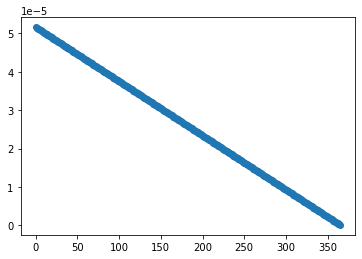

'Done.'

In [135]:
graph_absolute_error([sim_indoor_actual1]*len(sim_indoor_predicteds1), sim_indoor_predicteds1) 

Feature importance

In [121]:
food2 = food
food2 = food2.drop(columns=['site_id_msba', 'calendar.calendar_day_date','capital_projects.soft_opening_date', 'calendar.day_of_week'])
columns12 = list(food2.iloc[:,1:].columns)
columns12.append('decision_tree_pred')
columns12.append('random_forests_pred')
columns12.append('extra_trees_pred')
columns12.append('SVM_pred')
columns12.append('ridge_pred')
columns12.append('OLS_pred')
meta_modelfood2 = meta_modelfood


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

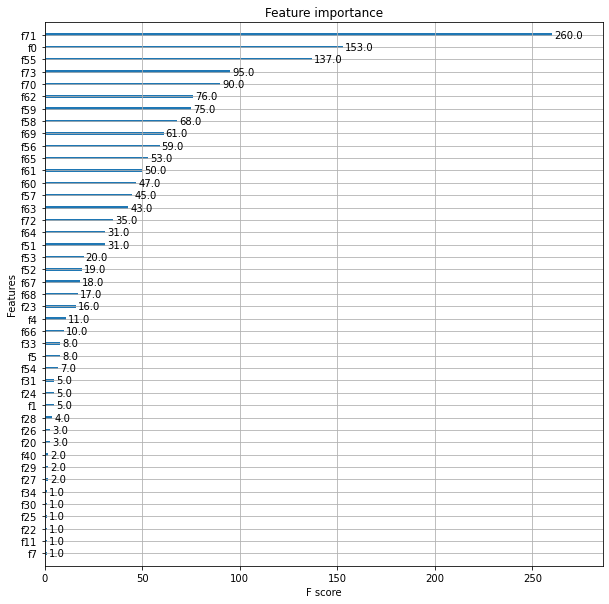

In [122]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(meta_modelfood2,max_num_features=75, ax=ax)

In [123]:
columns12[59]

'daily_yoy_ndt.total_food_service (t-4)'

In [124]:
indoor2 = indoor
indoor2 = indoor2.drop(columns=['site_id_msba', 'calendar.calendar_day_date','capital_projects.soft_opening_date', 'calendar.day_of_week'])
columns123 = list(food2.iloc[:,1:].columns)
columns123.append('decision_tree_pred')
columns123.append('random_forests_pred')
columns123.append('extra_trees_pred')
columns123.append('SVM_pred')
columns123.append('ridge_pred')
columns123.append('OLS_pred')
meta_modelindoor2 = meta_modelindoor

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

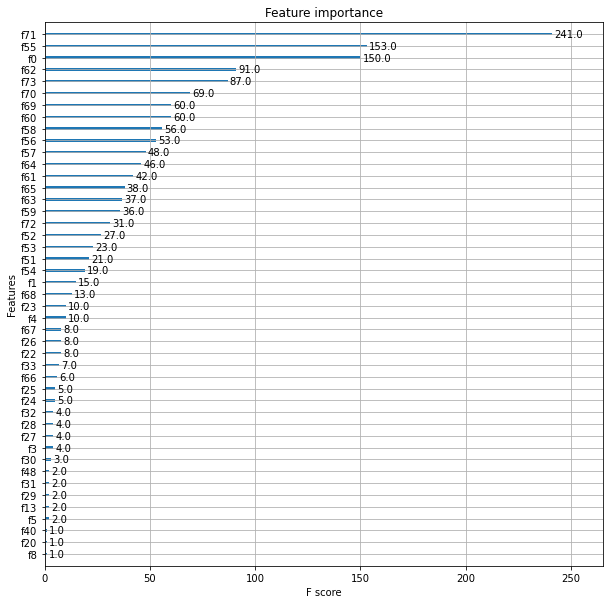

In [125]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(meta_modelindoor2,max_num_features=75, ax=ax)

In [126]:
columns123[70]

'random_forests_pred'

In [127]:
diesel2 = diesel
diesel2 = diesel2.drop(columns=['site_id_msba', 'calendar.calendar_day_date','capital_projects.soft_opening_date', 'calendar.day_of_week'])
columns23 = list(diesel2.iloc[:,1:].columns)
columns23.append('decision_tree_pred')
columns23.append('random_forests_pred')
columns23.append('extra_trees_pred')
columns23.append('SVM_pred')
columns23.append('ridge_pred')
columns23.append('OLS_pred')
meta_modeldiesel2 = meta_modeldiesel

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

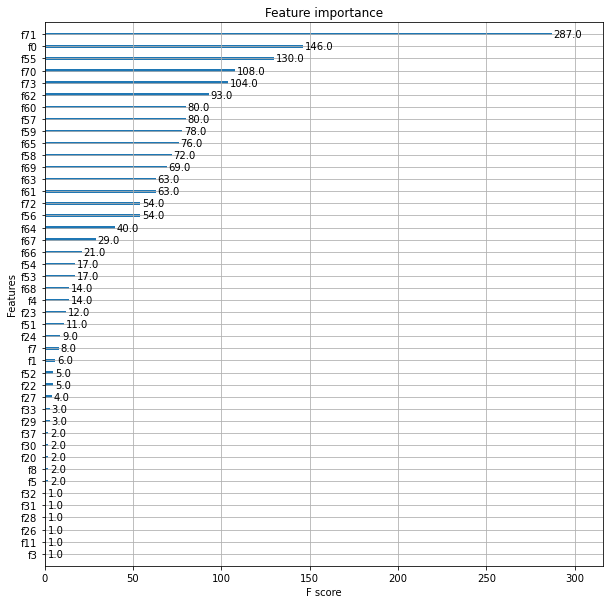

In [128]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(meta_modeldiesel2,max_num_features=75, ax=ax)

In [129]:
columns23[62]

'diesel (t-7)'

In [107]:
unleaded2 = unleaded
unleaded2 = unleaded2.drop(columns=['site_id_msba', 'calendar.calendar_day_date','capital_projects.soft_opening_date', 'calendar.day_of_week'])
#column_to_move = unleaded2.pop("full_days_open")
#unleaded2.insert(2,'full_days_open',column_to_move)
columns34 = list(unleaded2.iloc[:,1:].columns)
columns34.append('decision_tree_pred')
columns34.append('random_forests_pred')
columns34.append('extra_trees_pred')
columns34.append('SVM_pred')
columns34.append('ridge_pred')
columns34.append('OLS_pred')
meta_modelunleaded2 = meta_modelunleaded

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

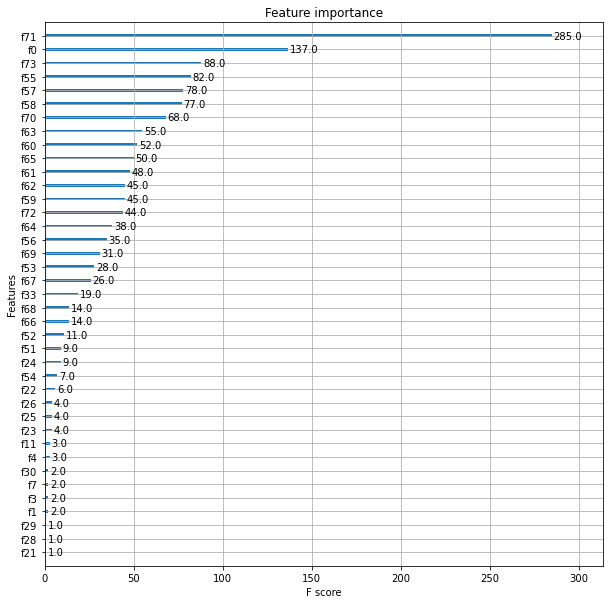

In [109]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(meta_modelunleaded2,max_num_features=75, ax=ax)

In [120]:
columns34[58]

'unleaded (t-3)'

In [136]:
#meta_modelindoor.save_model('indoor_model.model')
#meta_modelindoor = xgb.Booster({'nthread': 4})  # init model
#meta_modelindoor.load_model('~/Desktop/UtahMSBA/Capstone3/models/indoor_model.model')

In [139]:
#meta_modelfood.save_model('food_model.model')
#meta_modelfood = xgb.Booster({'nthread': 4})  # init model
#meta_modelfood.load_model('~/Desktop/UtahMSBA/Capstone3/models/food_model.model')

In [140]:
#meta_modeldiesel.save_model('diesel_model.model')
#meta_modeldiesel = xgb.Booster({'nthread': 4})  # init model
#meta_modeldiesel.load_model('~/Desktop/UtahMSBA/Capstone3/models/diesel_model.model')

In [141]:
#meta_modelunleaded.save_model('unleaded_model.model')
#meta_modelunleaded = xgb.Booster({'nthread': 4})  # init model
#meta_modelunleaded.load_model('~/Desktop/UtahMSBA/Capstone3/models/unleaded_model.model')